# Bachelier 

We consider the Bachelier model for a call option with European payoff $(S_T - K)^+$:

$$
d{F_t} = \sigma d{W_t},
$$

where:
- $d{W_t}$ denotes a Wiener process
- $\sigma$ is the constant volatility

This is a simplified view using a forward measure and forward price: $F_t=S_t e^{r(T-t)}$, where $r$ is the risk-free interest rate.

Furthermore, consider Gaussian basket: $$F_t = \sum_{i=0}^{m} \omega_i F^{[i]}_t.$$
It is a weighted sum of the underlying jointly Gaussian distributed assets.
Unlike lognormally distributed prices, the basket price $F_t$ is again Gaussian.
That is why the Bachelier model is again applicable.

In the following code the spot and forward price are used interchangibly.


We can discretize this SDE using, e.g., the Euler-Maryuama scheme. Then the samples for training are computed using Monte Carlo and the pathwise derivative method. 

# General Imports and Settings

In [1]:
# Make sure the following packages are installed:
# matplotlib, numpy, jaxlib, jax, jaxtyping, optax, chex, tensorflow, tensorflow-datasets

%pip install matplotlib
%pip install numpy

# install required jax packages
%pip install --upgrade "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
%pip install equinox jaxtyping optax chex

# install tensorflow datasets for data loading
%pip install tensorflow
%pip install tensorflow-datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# For Google Colab
%pip install jaxtyping
%pip install equinox

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# option to disable preallocation. Otherwise Jax will commit 90% of VRAM (GPU) 
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Callable, Literal
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

# we use tf with tfds for loading the data
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
# Note: The warnings from tf can safely be ignored.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

# check for nans etc.
jax.enable_checks = True

2023-11-28 10:53:35.255595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 10:53:35.255686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 10:53:35.952514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 10:53:50.708760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# check if jax recognizes the GPU
jax.devices()

[cuda(id=0)]

In [3]:
# list requirements of latest run
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.4.20
equinox==0.11.1
optax==0.1.7
chex==0.1.83
tensorflow==2.15.0
tensorflow_datasets==4.9.3
numpy==1.24.4


In [6]:
# optional style change for print-ready figures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "EB Garamond",
    "font.size": 20
})

In [4]:
# global settings

NUM_EPOCHS = 100
BATCH_SIZE = 512
BUFFER_SIZE = 1024
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096
SEED = 42

In [5]:
# helper functions

@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

In [6]:
def mse(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.mean((y - pred_y) ** 2)

In [7]:
def rmse(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.sqrt(mse(y, pred_y))

# Smoothing

In [8]:
def sigmoidal_smoothing(f1: Callable, f2: Callable, p=0.0, w=0.005):
    """
    Smoothly transition between two functions using sigmoidal smoothing.

    Args:
        f1 (callable): The first function, f1(x), where x is a real number.
        f2 (callable): The second function, f2(x), where x is a real number.
        p (float, optional): The position to transition between the two functions. Default is 0.0.
        w (float, optional): The width of the smoothing. Default is 0.005.

    Returns:
        callable: A function that smoothly transitions between f1 and f2 at point p.

    Example:
        zero_fn = lambda x: jnp.zeros_like(x)
        id_fn   = lambda x: x
        smooth_fn = sigmoidal_smoothing(zero_fn, id_fn, p=1.0, w=0.01)
        result = smooth_fn(0.5)
    """

    def sigma(x):
        """
        Sigmoid function for smoothing.

        Args:
            x (float): The input value.

        Returns:
            float: The result of the sigmoid function.
        """
        return 1.0 / (1.0 + jnp.exp(-(x-p)/w))

    def smooth_f(x):
        """
        Smoothed function.

        Args:
            x (float): The input value.

        Returns:
            float: The result of the smoothed function.
        """
        return (1 - sigma(x)) * f1(x) + sigma(x) * f2(x)

    return smooth_f


In [9]:
smooth_relu = sigmoidal_smoothing(lambda x: jnp.zeros_like(x), lambda x: x)
smooth_relu_fn = lambda w: sigmoidal_smoothing(lambda x: jnp.zeros_like(x), lambda x: x, w=w)

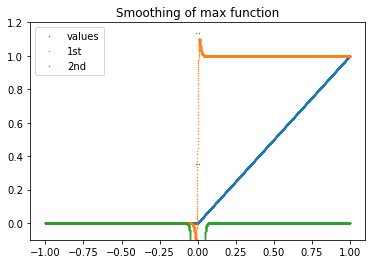

In [10]:
xs = jnp.linspace(-1e-0, 1e-0, 10000)
ys = smooth_relu(xs)
dys = jax.vmap(jax.grad(smooth_relu))(xs)
ddys = jax.vmap(jax.hessian(smooth_relu))(xs)


plt.title("Smoothing of max function")
plt.plot(xs, ys, '.', markersize=1.0, label="values")
plt.plot(xs, dys, '.', markersize=1.0, label="1st")
plt.plot(xs, ddys, '.', markersize=1.0, label="2nd")
plt.ylim([-0.1, 1.2])
plt.legend()
plt.show()

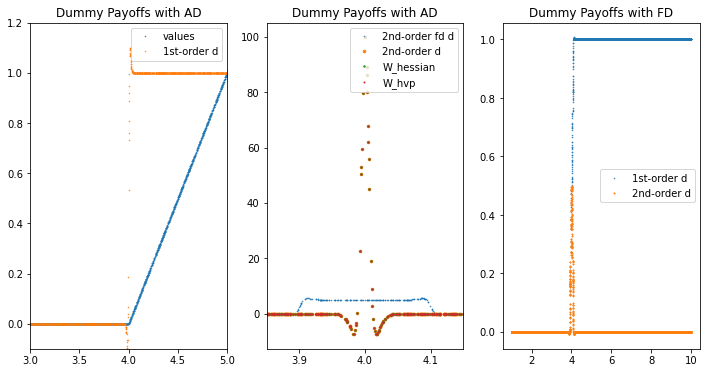

In [11]:
# Example visualizaiton of smoothed payoff and its (second-order) derivative
K = 4

def dummy_payoff(xs, K=4):
    return jnp.maximum(0, xs - K)

smoothed_dummy_payoff = lambda x, K=4: smooth_relu(x - K)
dummy_payoff = smoothed_dummy_payoff

seed = 42
n = N_TRAINING_SAMPLES
key = random.PRNGKey(seed)
key, subkey = random.split(key)
xs = random.uniform(subkey, shape=(n,), minval=1.0, maxval=10.0)
ys = dummy_payoff(xs)

# AD
dpayoff = grad(dummy_payoff)
dys = vmap(dpayoff)(xs)
ddys = vmap(grad(dpayoff))(xs)

Z_jacobian = jax.vmap(jax.jacobian(dummy_payoff))(xs)
assert(jnp.allclose(dys, Z_jacobian))
W_hessian = jax.vmap(jax.hessian(dummy_payoff))(xs)
assert(jnp.allclose(ddys, W_hessian))

Y_vjp, vjpfun = jax.vjp(dummy_payoff, xs)
basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
W_hvp = jax.jvp(jax.vmap(jax.grad(dummy_payoff)), (xs, ), (jnp.ones_like(xs), ))[1]

# FD over AD
h = 0.1
fd_xph = vmap(dpayoff)(xs + h)
fd_xmh = vmap(dpayoff)(xs - h)
ddys_fd = (fd_xph - fd_xmh) / (2 * h)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# First plot
axs[0].set_title("Dummy Payoffs with AD")
axs[0].plot(xs, ys, '.', markersize=1, label='values')
axs[0].plot(xs, dys, '.', markersize=1, label='1st-order d')
axs[0].set_xlim([K-1, K+1])
axs[0].set_ylim([-.1, 1.2])
axs[0].legend()

# Second plot
axs[1].set_title("Dummy Payoffs with AD")
axs[1].plot(xs, ddys_fd, '.', markersize=1, label='2nd-order fd d')
axs[1].plot(xs, ddys, '.', markersize=5, label='2nd-order d')
axs[1].plot(xs, W_hessian, '.', markersize=3, label='W_hessian')
axs[1].plot(xs, W_hvp, '.', markersize=2, label='W_hvp')
axs[1].set_xlim([K-1.5e-1, K+1.5e-1])
axs[1].legend()

# FD
h = 0.1
fd_xph = dummy_payoff(xs + h)
fd_xmh = dummy_payoff(xs - h)
fd = (fd_xph - fd_xmh) / (2 * h)
fdd = (fd_xph - 2 * ys + fd_xmh) / (2 * h)

# Third plot
axs[2].set_title("Dummy Payoffs with FD")
axs[2].plot(xs, fd, '.', markersize=1, label='1st-order d')
axs[2].plot(xs, fdd, '.', markersize=2, label='2nd-order d')
axs[2].legend()

plt.show()

# Bachelier Dataset

## Analytic solution

In [10]:
# Initial Bachelier code was adapted from Huge & Savine, 2020, Differential Machine Learing

# analytic solutions
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)

def bachGamma(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.pdf(d) / (vol * jnp.sqrt(T))

def analytic_grad(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = jnp.maximum(0, bkt2 - K)

    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = jnp.maximum(0, bkt2a - K)
        
        # differentials
        Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z_analytic = 0.5 * (Z1 + Z2)
                
    else: # standard 
        Z_analytic = jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        jax.debug.print("analytic {}", jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)).shape)
        jax.debug.print("weights {}",  a.reshape((1,-1)).shape)
        jax.debug.print("z_analytic {}", Z_analytic.shape)

    return Z_analytic

## Training data generator

In [11]:
@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = False

class TrainingSet(eqx.Module):
    X: Array 
    Y: Array
    Z: Array
    W: Array
    weights: Array
    inc1: Array
    Z_fd: Array
    W_fd_of_fd: Array
    W_fd_of_vjp: Array
    W_fd_of_grad: Array

    def shapes(self):
        jax.debug.print("X {X}, Y {Y}, Z {Z}, W {W}", X=X.shape, Y=Y.shape, Z=Z.shape, W=W.shape)

class TestSet(eqx.Module):
    spots: Array
    baskets: Array
    prices: Array
    deltas: Array
    vegas: Array
    gammas: Array


def payoff_fn(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = smooth_relu(bkt2 - K)
    
    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = smooth_relu(bkt2a - K)
        Y = 0.5 * (pay + paya)
    else: # standard
        Y = pay

    return Y
    
# generate a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])

# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2) -> TrainingSet:
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)
    jax.debug.print("corr is {}", corr)
    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    jax.debug.print("basket asset weights are {}", a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    jax.debug.print("vols is {}", vols.shape)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    jax.debug.print("avols is {}", avols.shape)
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    jax.debug.print("v.shape is {}", v.shape)
    vols = vols * bktVol / v
    bktVol = bktVol
    jax.debug.print("bkt vol is= {v}", v=bktVol)

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    jax.debug.print("diagv {}", diagv.shape)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    jax.debug.print("cov {}", cov.shape)
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))

    jax.debug.print("normals 0 is {}", normals[0, :, :].shape)
    jax.debug.print("chol0 is {}", chol0.T.shape)
    inc0 = normals[0, :, :] @ chol0.T

    jax.debug.print("inc0.shape is {}", inc0.shape)
    
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

      
    payoff = partial(payoff_fn, a=a, K=K, anti=params.anti)

    Z_analytic = analytic_grad(S1, inc1, a, K, anti=params.anti)
    # Compute the values and obtain a VJP function
    Y_vjp, vjpfun = jax.vjp(payoff, S1, inc1)
    Z_vjp = vjpfun(jnp.ones(Y_vjp.size))[0]
    
    # if not independent, we need to use the commented out section instead
    basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
    Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function

    # using first order finite differences
    h = 1e-4
    fd_ph = payoff(S1 + h, inc1)
    fd_mh = payoff(S1 - h, inc1)
    Z_fd = (fd_ph - fd_mh) / (2 * h)

    # using second order finite differences
    h = 1e-2
    fdd = (fd_ph - 2 * Y_vjp + fd_mh) / (h * h)
    W_fd_of_fd = fdd[..., jnp.newaxis]

    # using first order finite difference over vjp
    h = 1e-4
    fd_of_vjp_ph = vjpfun(jnp.ones(Y_vjp.size) + h)[0]
    fd_of_vjp_mh  = vjpfun(jnp.ones(Y_vjp.size) - h)[0]
    W_fd_of_vjp = (fd_of_vjp_ph - fd_of_vjp_mh) / (2 * h)

    Dpayoff = vmap(jax.grad(payoff))
    W_fd_of_grad_ph = Dpayoff(S1 + h, inc1)
    W_fd_of_grad_mh = Dpayoff(S1 - h, inc1)
    W_fd_of_grad = (W_fd_of_grad_ph - W_fd_of_grad_mh) / (2 * h)

    Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    jax.debug.print("Example values: {val1}, {val2}", val1=Z_grad[2,0], val2=Z_vjp[2,0])
    jax.debug.print("MSE(W_fd_of_fd, W_fd_of_vjp): {mse}", mse=mse(W_fd_of_fd, W_fd_of_vjp))
    jax.debug.print("MSE(Z_grad, Z_analytic) = {res}", res=mse(Z_grad, Z_analytic))
    jax.debug.print("MSE(Z_vjp, Z_analytic) = {res}", res=mse(Z_vjp, Z_analytic))
    jax.debug.print("MSE(Y_vjp, Y) = {res}", res=mse(Y_vjp, Y))
    jax.debug.print("Close(Y_vjp, Y) ? {res}", res=jnp.allclose(Y_vjp, Y))
    jax.debug.print("Close(Z_vjp, Z) ? {res}", res=jnp.allclose(Z_vjp, Z_analytic, rtol=1e-4, atol=1e-0))
    jax.debug.print("Close(Z_grad, Z) ? {res}", res=jnp.allclose(Z_grad, Z_analytic, rtol=1e-4, atol=1e-0))

    W_hessian = jax.vmap(jax.hessian(payoff, argnums=0))(S1, inc1)
    
    X = S1
    return TrainingSet(X, Y_vjp.reshape(-1,1), Z_vjp, W_hessian, a, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad)


## Test data generator

In [12]:
def testSet(params: BachelierParams, training_set: TrainingSet, n_samples:int=4096, seed:int=42) -> TestSet:
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    weights = training_set.weights
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1)
    gammas = bachGamma(baskets, K, bktVol, T2 - T1)
    return TestSet(spots, baskets, prices, deltas, vegas, gammas) 

## Data generation

### 1D for visualization

In [13]:
bachelier_params = BachelierParams(n_dim=1, anti=True)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad = astuple(training_set)

test_set = testSet(bachelier_params, training_set, n_samples=10 * N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)

inc0.shape is (array(8192), array(1))
chol0 is (array(1), array(1))
normals 0 is (array(8192), array(1))
cov (array(1), array(1))
diagv (array(1), array(1))
bkt vol is= 0.2
v.shape is (array(1),)
avols is (array(1), array(1))
vols is (array(1),)
basket asset weights are [1.]
corr is [[1.]]
Example values: 1.0, 1.0
MSE(W_fd_of_fd, W_fd_of_vjp): 0.30469131302001895
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True
MSE(Z_grad, Z_analytic) = 0.0005660154384085881
MSE(Z_vjp, Z_analytic) = 0.0005660154384085881
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True


#### Plot generated Data

In [14]:
def plot_payoff_data(axs, x_train, y_train, x_test, y_test):
    axs.set_title("Payoff Data")
    axs.plot(x_train, y_train, '.', label='Payoff Training', markersize=1)
    axs.plot(x_test, y_test, '.', label='Payoff Test', markersize=1)
    axs.legend()

def plot_delta_data(axs, x_train, x_test, dydx_train, dydx_test):
    axs.set_title("Delta Data")
    axs.plot(x_train, dydx_train, '.', label='Delta Training', markersize=1)
    axs.plot(x_test, dydx_test, '.', label='Delta Test', markersize=1)
    axs.legend()

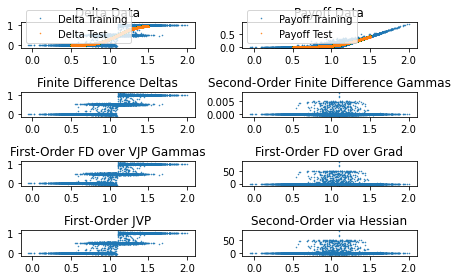

In [15]:
fig, axs = plt.subplots(4, 2)

Xs = X

plot_payoff_data(axs[0, 1], Xs, Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(axs[0, 0], Xs, baskets[:, 0], Z[:,0], deltas[:,0])

axs[1, 0].set_title("Finite Difference Deltas")
axs[1, 0].plot(Xs, Z_fd, '.', label='FD', markersize=1)
axs[1, 1].set_title("Second-Order Finite Difference Gammas")
axs[1, 1].plot(Xs, W_fd_of_fd, '.', label='FD', markersize=1)

axs[2, 0].set_title("First-Order FD over VJP Gammas")
axs[2, 0].plot(Xs, W_fd_of_vjp, ".", label='FD', markersize=1)
axs[2, 1].set_title("First-Order FD over Grad")
axs[2, 1].plot(Xs, W_fd_of_grad, ".", label='FD', markersize=1)

axs[3, 0].set_title("First-Order JVP")
axs[3,0].plot(Xs, Z, ".", markersize=1)
axs[3, 1].set_title("Second-Order via Hessian")
axs[3,1].plot(Xs, W[:, 0, 0], ".", markersize=1)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()


### 7D for training

In [16]:
use_anti = True
bachelier_params = BachelierParams(n_dim=7, anti=use_anti)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K, anti=use_anti)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.2
inc0.shape is (array(8192), array(7))
chol0 is (array(7), array(7))
normals 0 is (array(8192), array(7))
cov (array(7), array(7))
diagv (array(7), array(7))
v.shape is (array(1),)
avols is (array(7), array(1))
vols is (array(7),)
basket asset weights are [0.03523608 0.1942886  0.20768846 0.20812615 0.0497394  0.07701987
 0.22790145]
corr is [[ 1.         -0.40546809 -0.47076783  0.11005226  0.14389416  0.51420213
   0.42370432]
 [-0.40546809  1.          0.0184815  -0.10023294 -0.09547748 -0.04642767
   0.14553872]
 [-0.47076783  0.0184815   1.         -0.26878084  0.00815408 -0.34896792
  -0.41113086]
 [ 0.11005226 -0.10023294 -0.26878084  1.          0.03660357  0.48016104
  -0.35015074]
 [ 0.14389416 -0.09547748  0.00815408  0.03660357  1.         -0.06546545
   0.12895142]
 [ 0.51420213 -0.04642767 -0.34896792  0.48016104 -0.06546545  1.
  -0.07214193]
 [ 0.42370432  0.14553872 -0.41113086 -0.35015074  0.12895142 -0.07214193
   1.        ]]
MSE(Y_vjp, Y) = 0.0
Close

#### Plot generated Data

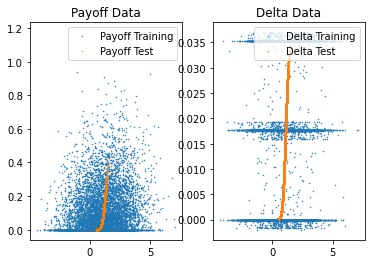

In [17]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

In [18]:
baskets_normalized = (baskets - jnp.mean(X)) / jnp.std(X)

In [19]:
prices_normalized = (prices - jnp.mean(Y)) / jnp.std(Y)

In [20]:
jnp.std(baskets_normalized)

Array(0.16457392, dtype=float64)

In [21]:
jnp.std(prices_normalized)

Array(0.47063096, dtype=float64)

# Standard ML

In [22]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [23]:
x_train = X
y_train = Y
dydx_train = Z

In [24]:
# Hyperparameters
# batch_size = 128
# learning_rate = 0.01
num_epochs = NUM_EPOCHS
seed = 42

key = jax.random.PRNGKey(seed)

In [25]:
# modified mlp
from typing import Optional

Linear = eqx.nn.Linear

class shrinkMLP(eqx.Module):
    """Standard Multi-Layer Perceptron; also known as a feed-forward network.

    !!! faq

        If you get a TypeError saying an object is not a valid JAX type, see the
            [FAQ](https://docs.kidger.site/equinox/faq/)."""

    layers: tuple[Linear, ...]
    activation: Callable
    final_activation: Callable
    use_bias: bool = eqx.field(static=True)
    use_final_bias: bool = eqx.field(static=True)
    in_size: Union[int, Literal["scalar"]] = eqx.field(static=True)
    out_size: Union[int, Literal["scalar"]] = eqx.field(static=True)
    width_size: int = eqx.field(static=True)
    depth: int = eqx.field(static=True)

    def __init__(
        self,
        in_size: Union[int, Literal["scalar"]],
        out_size: Union[int, Literal["scalar"]],
        width_size: int,
        depth: int,
        activation: Callable = jax.nn.relu,
        final_activation: Callable = lambda x: x,
        use_bias: bool = True,
        use_final_bias: bool = True,
        *,
        key,
        **kwargs,
    ):
        """**Arguments**:

        - `in_size`: The input size. The input to the module should be a vector of
            shape `(in_features,)`
        - `out_size`: The output size. The output from the module will be a vector
            of shape `(out_features,)`.
        - `width_size`: The size of each hidden layer.
        - `depth`: The number of hidden layers, including the output layer.
            For example, `depth=2` results in an network with layers:
            [`Linear(in_size, width_size)`, `Linear(width_size, width_size)`,
            `Linear(width_size, out_size)`].
        - `activation`: The activation function after each hidden layer. Defaults to
            ReLU.
        - `final_activation`: The activation function after the output layer. Defaults
            to the identity.
        - `use_bias`: Whether to add on a bias to internal layers. Defaults
            to `True`.
        - `use_final_bias`: Whether to add on a bias to the final layer. Defaults
            to `True`.
        - `key`: A `jax.random.PRNGKey` used to provide randomness for parameter
            initialisation. (Keyword only argument.)

        Note that `in_size` also supports the string `"scalar"` as a special value.
        In this case the input to the module should be of shape `()`.

        Likewise `out_size` can also be a string `"scalar"`, in which case the
        output from the module will have shape `()`.
        """

        super().__init__(**kwargs)
        keys = jrandom.split(key, depth + 1)
        layers = []
        if depth == 0:
            layers.append(Linear(in_size, out_size, use_final_bias, key=keys[0]))
        else:
            layers.append(Linear(in_size, width_size, use_bias, key=keys[0]))
            for i in range(depth - 1):
                layers.append(Linear(width_size - i, width_size - (i+1), use_bias, key=keys[i + 1]))
            layers.append(Linear(width_size - (depth-1), out_size, use_final_bias, key=keys[-1]))
        self.layers = tuple(layers)
        self.in_size = in_size
        self.out_size = out_size
        self.width_size = width_size
        self.depth = depth
        self.activation = activation
        self.final_activation = final_activation
        self.use_bias = use_bias
        self.use_final_bias = use_final_bias

    def __call__(self, x: Array, *, key = None) -> Array:
        """**Arguments:**

        - `x`: A JAX array with shape `(in_size,)`. (Or shape `()` if
            `in_size="scalar"`.)
        - `key`: Ignored; provided for compatibility with the rest of the Equinox API.
            (Keyword only argument.)

        **Returns:**

        A JAX array with shape `(out_size,)`. (Or shape `()` if `out_size="scalar"`.)
        """
        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.activation(x)
        x = self.layers[-1](x)
        x = self.final_activation(x)
        return x

In [26]:
def x_normalizer(x):
    return (x - x_train_mean) / x_train_std

def y_denormalizer(x):
    return x * y_train_std + y_train_mean

class MLP_Normalized(eqx.Module):
    layers: list
    in_size: Union[int, Literal["scalar"]] = eqx.field(static=True)
    out_size: Union[int, Literal["scalar"]] = eqx.field(static=True)
    dropout: eqx.nn.Dropout
    rng_key: Array
    
    def __init__(self, key, in_size, out_size):
        key, subkey = jax.random.split(key)
        key, mlp_key = jax.random.split(key)
        self.layers = [x_normalizer, 
                       # eqx.nn.MLP(key=subkey, in_size=in_size, out_size=out_size, width_size=20, depth=3, activation=jax.nn.silu), 
                       # shrinkMLP(key=subkey, in_size=in_size, out_size=out_size, width_size=20, depth=3, activation=jax.nn.silu), 
                       eqx.nn.MLP(key=mlp_key, in_size=in_size, out_size=out_size, width_size=128, depth=6, activation=smooth_relu_fn(w=1.0)),
                       y_denormalizer]
        self.dropout = eqx.nn.Dropout()
        self.rng_key = key
        self.in_size = in_size
        self.out_size= out_size

    def __call__(self, x, key=None):
        for layer in self.layers:
            x = layer(x)
                   
        # x = self.dropout(x, key=key)
        
        return x

In [27]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
    out, in_ = weight.shape
    stddev = jnp.sqrt(1 / in_)
    return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    new_model = eqx.tree_at(get_weights, model, new_weights)
    return new_model


In [28]:
@eqx.filter_jit
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], keys = None) -> Float:
    pred_y = vmap(model)(x, keys)
    pred_y = pred_y[:, jnp.newaxis]
    result = mse(y, pred_y)
    return result

In [29]:
def evaluate(model, testloader):
    """
    This function evaluates the model on the test dataset,
    computing both the average loss.
    """
    avg_loss = 0
    for (x, y, _) in testloader:
        avg_loss += loss_fn(model, x, y)
    return avg_loss / len(testloader)

## Train

In [30]:
def train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS,
          key = None) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   key):
        keys = jax.random.split(key, len(x))
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y, keys=keys)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    if key is None:
        key = jax.random.PRNGKey(0)
    
    for epoch in range(n_epochs):
        for (batch_x, batch_y, _) in generator_train_ds:
            key, subkey = jax.random.split(key)
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, subkey)

        eval_model = eqx.nn.inference_mode(model)
        test_loss = jnp.sqrt(evaluate(eval_model, generator_test_ds))
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [31]:
def gen_data_standard_ml():
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
    
    x_test = spots
    y_test = prices
    dydx_test = deltas
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))
    
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    generator_train_ds = tfds.as_numpy(train_dataset)
    generator_test_ds = tfds.as_numpy(test_dataset)
    return generator_train_ds, generator_test_ds, x_test

In [32]:
import jax.random as jrandom
modeltest = MLP_Normalized(key, in_size=x_train.shape[1], out_size="scalar")

In [33]:
def bachelier_train_standard_ml(key: Array):
    key, subkey = jax.random.split(key)
    model = MLP_Normalized(key, in_size=x_train.shape[1], out_size="scalar")
    
    key, subkey = jax.random.split(key)
    model = init_linear_weight(model, trunc_init, key)
    
    # use linear on-cycle decay scheduler
    num_epochs = 200
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    # print(total_steps)
    # lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
    #                                                                  pct_start=0.2, pct_final=0.6,
    #                                                                  div_factor=1000., final_div_factor=1.0e4)
    
    
    # lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
    
    # lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
    # lr_schedule = optax.constant_schedule(0.0001)
    # lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    
    optim = optax.adam(learning_rate=0.0001)
    # optim = optax.adam(learning_rate=lr_schedule)
    model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)
    return model

In [34]:
generator_train_ds, generator_test_ds, x_test = gen_data_standard_ml()
key = jax.random.PRNGKey(42)
model_ml = bachelier_train_standard_ml(key)

Finished epoch   0  | Train Loss: 0.01875  | Test Loss: 0.08052
Finished epoch   1  | Train Loss: 0.01649  | Test Loss: 0.07585
Finished epoch   2  | Train Loss: 0.01610  | Test Loss: 0.07120
Finished epoch   3  | Train Loss: 0.01342  | Test Loss: 0.06439
Finished epoch   4  | Train Loss: 0.00853  | Test Loss: 0.05669
Finished epoch   5  | Train Loss: 0.00807  | Test Loss: 0.04991
Finished epoch   6  | Train Loss: 0.00500  | Test Loss: 0.03928
Finished epoch   7  | Train Loss: 0.00370  | Test Loss: 0.03237
Finished epoch   8  | Train Loss: 0.00334  | Test Loss: 0.02724
Finished epoch   9  | Train Loss: 0.00253  | Test Loss: 0.02441
Finished epoch  10  | Train Loss: 0.00229  | Test Loss: 0.02180
Finished epoch  11  | Train Loss: 0.00197  | Test Loss: 0.02065
Finished epoch  12  | Train Loss: 0.00219  | Test Loss: 0.01962
Finished epoch  13  | Train Loss: 0.00192  | Test Loss: 0.01846
Finished epoch  14  | Train Loss: 0.00187  | Test Loss: 0.01773
Finished epoch  15  | Train Loss: 0.0018

In [35]:
model_ml = eqx.nn.inference_mode(model_ml)

In [36]:
class Predictions(eqx.Module):
    y: Array
    dydx: Array
    ddyddx: Array

@eqx.filter_jit
def predict(model, xs):
    pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(model))(xs)
    pred_ddyddx = vmap(jax.hessian(model))(xs)

    return Predictions(pred_y, pred_dydx, pred_ddyddx)
    

In [37]:
pred = predict(model_ml, x_test)

In [51]:
@eqx.filter_jit
def eval(pred: Predictions, test_set: TestSet, eval_fn=rmse):
    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]
    pred_gammas = jnp.sum(pred.ddyddx, axis=(1, 2))
    print(pred_gammas.shape)
    print(gammas.shape)
    
    eval_y = eval_fn(pred_y, y_test)
    eval_dydx = eval_fn(pred_dydx, dydx_test)
    eval_ddyddx = eval_fn(pred_gammas, gammas)
    
    
    return eval_y, eval_dydx, eval_ddyddx

## Plot results

In [52]:
def r2_score(pred_y, y):
    """
    As defined in:
       https://en.wikipedia.org/wiki/Coefficient_of_determination#Definitions
    """
    res_sum_of_squares = jnp.sum((y-pred_y)**2)
    tot_sum_of_squares = jnp.sum((y - jnp.mean(y))**2)
    return 1 - res_sum_of_squares / tot_sum_of_squares

In [53]:
class R2_Score:
    
    def __str__(self):
        return "R2-score"
    
    def __call__(self, pred_y, y):
        return r2_score(pred_y, y)

### For notebook

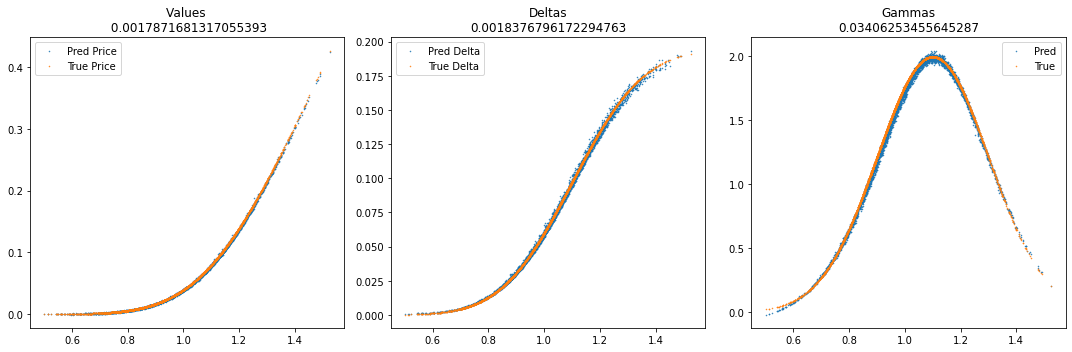

In [68]:
import datetime

def plot_eval(model, pred: Predictions, test_set: TestSet, method: str, eval_fn=rmse):

    def print_rmse(pred, true):
        plt.title(f"RMSE: {eval_fn(true, pred)}")

    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]

    # Create a single figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first subplot
    axes[0].plot(baskets, pred_y, '.', markersize=1)
    axes[0].plot(baskets, y_test, '.', markersize=1)
    axes[0].legend(['Pred Price', 'True Price'], loc='upper left')
    axes[0].set_title(f"Values \n {eval_fn(pred_y, y_test)}")

    # Plot the second subplot
    dydx_idx = 1
    axes[1].plot(baskets, pred_dydx[:, dydx_idx], '.', markersize=1)
    axes[1].plot(baskets, dydx_test[:, dydx_idx], '.', markersize=1)
    axes[1].legend(['Pred Delta', 'True Delta'], loc='upper left')
    axes[1].set_title(f"Deltas\n{eval_fn(pred_dydx, dydx_test)}")

    # Calculate and plot gammas in the third subplot
    pred_gammas = jnp.sum(pred_ddyddx, axis=(1, 2))
    gammas = gammas.squeeze()
    axes[2].plot(baskets, pred_gammas, '.', markersize=1, label='Pred')
    axes[2].plot(baskets, gammas, '.', markersize=1, label='True')
    axes[2].legend()
    axes[2].set_title(f"Gammas\n{eval_fn(pred_gammas, gammas)}")

    # Adjust the layout and save the figure to a PDF file
    plt.tight_layout()
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'results/all_at_once/eval_ml_{now}.pdf', bbox_inches='tight')

plot_eval(model_ml, pred, test_set, "ml")


### For latex

In [256]:
import datetime

BASE_PATH  = "results/single/"
VALUE_PATH = "values/"
DELTA_PATH = "deltas/"
GAMMA_PATH = "gammas/"

def plot_eval(model, pred: Predictions, test_set: TestSet, method: str, format: str = "pdf"):

    def print_rmse(pred, true):
        # plt.title(f"RMSE: {rmse(true, pred)}")
        print(f"RMSE: {rmse(true, pred)}")

    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]

    
    fig = plt.figure()
    print_rmse(pred_y, y_test)
    # plt.suptitle("Evaluation")
    plt.plot(baskets, pred_y, '.', markersize=1)
    plt.plot(baskets, y_test, '.', markersize=1)
    # plt.ylabel(r'$V$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend(['Pred Price', 'True Price'], loc='upper left')
    plt.show()
    
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{VALUE_PATH}eval_{method}_{now}.{format}', bbox_inches='tight')

    
    fig = plt.figure()
    print_rmse(pred_dydx, dydx_test)
    # plt.suptitle("Differentials")
    dydx_idx = 0
    plt.plot(baskets, pred_dydx[:, dydx_idx], '.', markersize=1)
    plt.plot(baskets, dydx_test[:, dydx_idx], '.', markersize=1)
    # plt.ylabel(r'$\frac{\partial V}{\partial S_0}$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{DELTA_PATH}eval_delta_{method}_{now}.{format}', bbox_inches='tight')


    pred_gammas = jnp.sum(pred.ddyddx, axis=(1, 2))

    fig = plt.figure()
    print_rmse(pred_gammas, gammas)
    # plt.suptitle("Gammas")
    plt.plot(baskets, pred_gammas, '.', markersize=1, label='Pred')
    plt.plot(baskets, gammas, '.', markersize=1, label='True')
    # plt.ylabel(r'$\frac{\partial^2 V}{\partial S_0^2}$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend()
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{GAMMA_PATH}eval_gamma_{method}_{now}.{format}', bbox_inches='tight')


In [257]:
plot_eval(model, pred, test_set, "standard_ml")

NameError: name 'model' is not defined

# Differential ML

## Data generation

In [105]:
@eqx.filter_jit
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)

    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    value_loss = alpha * jnp.mean((y_pred - y)**2)
    grad_loss = beta * jnp.mean((dydx_pred - dydx)**2)
    loss = value_loss + grad_loss

    # jax.debug.print('[Internal] Value Loss {value_loss} | Grad Loss: {grad_loss}', value_loss=value_loss, grad_loss=grad_loss)
    return loss

In [106]:
def optimal_step(x: Float):
    h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
    return h * jnp.fabs(x)

## Train

In [107]:
def diff_train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, batch_dydx) in generator_train_ds:
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

        test_loss = rmse(vmap(model)(x_test), y_test)
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

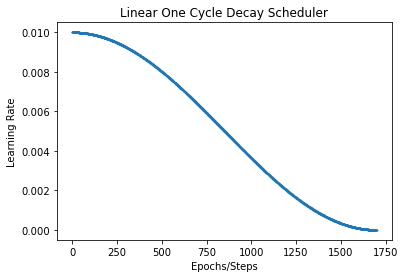

In [108]:
# linear_onecycle_decay_scheduler = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=100., final_div_factor=1.0e6)

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                 pct_start=0.2, pct_final=0.6,
#                                                 div_factor=100., final_div_factor=1.0e6)

lrs = vmap(lr_schedule)(jnp.arange(total_steps))
plt.scatter(range(total_steps), lrs, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

In [109]:
def gen_data_dml():
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
    
    x_test = spots
    y_test = prices
    dydx_test = deltas
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))
    
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    generator_train_ds = tfds.as_numpy(train_dataset)
    generator_test_ds = tfds.as_numpy(test_dataset)
    return generator_train_ds, generator_test_ds, x_test

In [110]:
def bachelier_train_dml(key: Array):
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    
    seed = SEED
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    model = MLP_Normalized(key, in_size=x_train.shape[1], out_size="scalar")
    
    key, subkey = jax.random.split(key)
    model = init_linear_weight(model, trunc_init, key)
    
    optim = optax.adam(learning_rate=lr_schedule)
    model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=100)
    return model

In [50]:
generator_train_ds, generator_test_ds, x_test = gen_data_dml()
y_test = prices
key = jax.random.PRNGKey(42)
model_dml = bachelier_train_dml(key)

Finished epoch   0  | Train Loss: 0.00329  | Test Loss: 0.07659
Finished epoch   1  | Train Loss: 0.00112  | Test Loss: 0.09777
Finished epoch   2  | Train Loss: 0.00099  | Test Loss: 0.09402
Finished epoch   3  | Train Loss: 0.00108  | Test Loss: 0.09300
Finished epoch   4  | Train Loss: 0.00097  | Test Loss: 0.09485
Finished epoch   5  | Train Loss: 0.00112  | Test Loss: 0.09420
Finished epoch   6  | Train Loss: 0.00105  | Test Loss: 0.09215
Finished epoch   7  | Train Loss: 0.00102  | Test Loss: 0.09411
Finished epoch   8  | Train Loss: 0.00113  | Test Loss: 0.09150
Finished epoch   9  | Train Loss: 0.00100  | Test Loss: 0.09213
Finished epoch  10  | Train Loss: 0.00105  | Test Loss: 0.09227
Finished epoch  11  | Train Loss: 0.00103  | Test Loss: 0.09248
Finished epoch  12  | Train Loss: 0.00102  | Test Loss: 0.09764
Finished epoch  13  | Train Loss: 0.00109  | Test Loss: 0.09547
Finished epoch  14  | Train Loss: 0.00112  | Test Loss: 0.09213
Finished epoch  15  | Train Loss: 0.0009

## Plot results

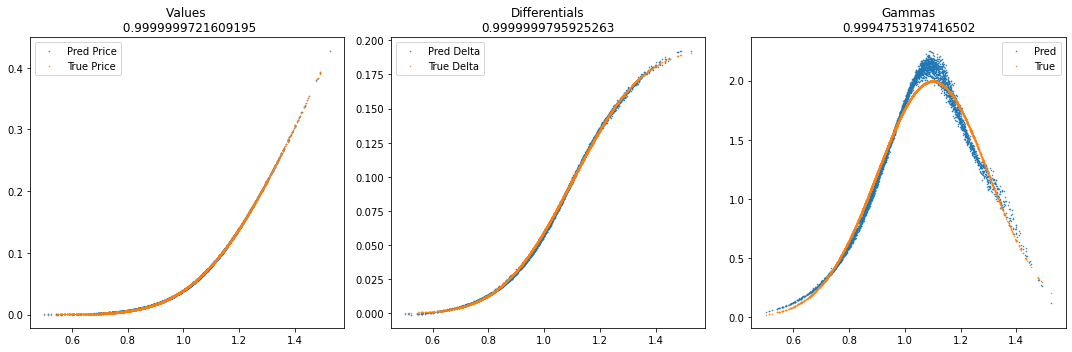

In [53]:
pred = predict(model_dml, x_test)
plot_eval(model_dml, pred, test_set, "dml")

In [54]:
x_test

Array([[0.39379209, 1.24119337, 0.93875004, ..., 1.45589919, 1.51265588,
        0.39868735],
       [0.62962889, 1.41686594, 1.63349651, ..., 0.87255395, 1.38699918,
        0.97456523],
       [1.42542072, 0.89373755, 1.61657339, ..., 0.9554269 , 0.98233569,
        0.68678153],
       ...,
       [1.59585986, 1.44146234, 1.52172116, ..., 0.92437608, 1.35633861,
        1.06645567],
       [1.34963439, 0.40877031, 0.87210423, ..., 1.32820543, 0.95856308,
        1.04407675],
       [0.85312947, 0.85668024, 1.48367909, ..., 0.65083588, 0.77122384,
        1.04332537]], dtype=float64)

# Save Validation data

In [41]:
path = "results/data/validation/"

In [56]:
np_baskets = np.array(test_set.baskets)
np.save(f"{path}bachelier_xs", np_baskets)

In [58]:
np_spots = np.array(test_set.spots)
np.save(f"{path}bachelier_xs_spots", np_spots)

In [59]:
np_prices = np.array(test_set.prices)
np.save(f"{path}bachelier_ys", np_prices)

In [60]:
np_deltas = np.array(test_set.deltas)
np.save(f"{path}bachelier_deltas", np_deltas)

In [61]:
np_gammas = np.array(test_set.gammas)
np.save(f"{path}bachelier_gammas", np_gammas)

# Save training data

In [46]:
path = "results/data/train/"

In [51]:
np.save(f"{path}bachelier_xs", np.array(x_train))

In [52]:
np.save(f"{path}bachelier_ys", np.array(y_train))

# Save trained models to onnx

In [42]:
from jax.experimental import jax2tf
import tf2onnx

In [43]:
def save_to_onnx(model, out_path):
    # NOTE: We need enable_xla=False because tf2onnx is not aware of some XLA
    #       specific TF ops (e.g. DotGeneral)
    nn_tf = jax2tf.convert(model, with_gradient=True, enable_xla=False)#, polymorphic_shapes=["(b, _)"])
    nn_tf = tf.function(nn_tf, autograph=False)
    
    nn_onnx = tf2onnx.convert.from_function(nn_tf, 
                                            input_signature=[tf.TensorSpec([model.in_size], jnp.float64)],
                                            output_path=out_path)
    return nn_onnx
    

In [54]:
# save vmapped version

def save_vmapped_to_onnx(model, out_path):
    # NOTE: We need enable_xla=False because tf2onnx is not aware of some XLA
    #       specific TF ops (e.g. DotGeneral)
    
    n_features = model.in_size
    model = eqx.filter_vmap(model)
    nn_tf = jax2tf.convert(model, with_gradient=True, enable_xla=False, polymorphic_shapes=["(b, _)"])
    nn_tf = tf.function(nn_tf, autograph=False)
    
    # n_batch_size = 1
    n_batch_size = 256
    nn_onnx = tf2onnx.convert.from_function(nn_tf, 
                                            input_signature=[tf.TensorSpec([n_batch_size, n_features], jnp.float64)],
                                            output_path=out_path)
    return nn_onnx
    

In [55]:
params, static = eqx.partition(model_ml, eqx.is_inexact_array)

In [56]:
def make_init_apply(model):
    params, static = eqx.partition(model, eqx.is_inexact_array)

    def init_fn():
        return params

    def apply_fn(_params, x):
        model = eqx.combine(_params, static)
        return model(x)

    return init_fn, apply_fn

In [57]:
init_fn, apply_fn = make_init_apply(model_ml)

In [90]:
"""Defines a helper function for creating a SavedModel from a jax2tf trained model.

This has been tested with TensorFlow Hub, TensorFlow JavaScript,
and TensorFlow Serving.

Note that the code in this file is provided only as an example. The functions
generated by `jax2tf.convert` are standard TensorFlow functions and you can
save them in a SavedModel using standard TensorFlow code. This decoupling
of jax2tf from SavedModel is important, because it allows the user to have full
control over what metadata is saved in the SavedModel. Please copy and
customize this function as needed.
"""

from collections.abc import Sequence
from typing import Any, Callable, Optional, Union

from jax.experimental import jax2tf  # type: ignore[import]
import tensorflow as tf  # type: ignore[import]


def convert_and_save_model(
    jax_fn: Callable[[Any, Any], Any],
    params,
    model_dir: str,
    *,
    input_signatures: Sequence[tf.TensorSpec],
    polymorphic_shapes: Optional[Union[str, jax2tf.PolyShape]] = None,
    with_gradient: bool = False,
    enable_xla: bool = True,
    compile_model: bool = True,
    saved_model_options: Optional[tf.saved_model.SaveOptions] = None):
  """Convert a JAX function and saves a SavedModel.

  This is an example, we do not promise backwards compatibility for this code.
  For serious uses, please copy and and expand it as needed (see note at the top
  of the module).

  Use this function if you have a trained ML model that has both a prediction
  function and trained parameters, which you want to save separately from the
  function graph as variables (e.g., to avoid limits on the size of the
  GraphDef, or to enable fine-tuning.) If you don't have such parameters,
  you can still use this library function but probably don't need it
  (see jax2tf/README.md for some simple examples).

  In order to use this wrapper you must first convert your model to a function
  with two arguments: the parameters and the input on which you want to do
  inference. Both arguments may be np.ndarray or (nested)
  tuples/lists/dictionaries thereof.

  See the README.md for a discussion of how to prepare Flax and Haiku models.

  Args:
    jax_fn: a JAX function taking two arguments, the parameters and the inputs.
      Both arguments may be (nested) tuples/lists/dictionaries of np.ndarray.
    params: the parameters, to be used as first argument for `jax_fn`. These
      must be (nested) tuples/lists/dictionaries of np.ndarray, and will be
      saved as the variables of the SavedModel.
    model_dir: the directory where the model should be saved.
    input_signatures: the input signatures for the second argument of `jax_fn`
      (the input). A signature must be a `tensorflow.TensorSpec` instance, or a
      (nested) tuple/list/dictionary thereof with a structure matching the
      second argument of `jax_fn`. The first input_signature will be saved as
      the default serving signature. The additional signatures will be used
      only to ensure that the `jax_fn` is traced and converted to TF for the
      corresponding input shapes.
    with_gradient: the value to use for the `with_gradient` parameter for
      `jax2tf.convert`.
    enable_xla: the value to use for the `enable_xla` parameter for
      `jax2tf.convert`.
    compile_model: use TensorFlow jit_compiler on the SavedModel. This
      is needed if the SavedModel will be used for TensorFlow serving.
    polymorphic_shapes: if given then it will be used as the
      `polymorphic_shapes` argument to jax2tf.convert for the second parameter of
      `jax_fn`. In this case, a single `input_signatures` is supported, and
      should have `None` in the polymorphic dimensions.
    saved_model_options: options to pass to savedmodel.save.
  """
  if not input_signatures:
    raise ValueError("At least one input_signature must be given")
  if polymorphic_shapes is not None:
    if len(input_signatures) > 1:
      raise ValueError("For shape-polymorphic conversion a single "
                       "input_signature is supported.")
  tf_fn = jax2tf.convert(
    jax_fn,
    with_gradient=with_gradient,
    polymorphic_shapes=[None, polymorphic_shapes],
    enable_xla=enable_xla)

  # Create tf.Variables for the parameters. If you want more useful variable
  # names, you can use `tree.map_structure_with_path` from the `dm-tree` package
  param_vars = tf.nest.map_structure(
    lambda param: tf.Variable(param, trainable=with_gradient),
    params)
  tf_graph = tf.function(lambda inputs: tf_fn(param_vars, inputs),
                         autograph=False,
                         jit_compile=compile_model)

  signatures = {}
  # This signature is needed for TensorFlow Serving use.
  signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY] = \
    tf_graph.get_concrete_function(input_signatures[0])
  for input_signature in input_signatures[1:]:
    # If there are more signatures, trace and cache a TF function for each one
    tf_graph.get_concrete_function(input_signature)
  wrapper = _ReusableSavedModelWrapper(tf_graph, param_vars)
  if with_gradient:
    if not saved_model_options:
      saved_model_options = tf.saved_model.SaveOptions(experimental_custom_gradients=True)
    else:
      saved_model_options.experimental_custom_gradients = True
  tf.saved_model.save(wrapper, model_dir, signatures=signatures,
                      options=saved_model_options)


class _ReusableSavedModelWrapper(tf.train.Checkpoint):
  """Wraps a function and its parameters for saving to a SavedModel.

  Implements the interface described at
  https://www.tensorflow.org/hub/reusable_saved_models.
  """

  def __init__(self, tf_graph, param_vars):
    """Args:

      tf_graph: a tf.function taking one argument (the inputs), which can be
         be tuples/lists/dictionaries of np.ndarray or tensors. The function
         may have references to the tf.Variables in `param_vars`.
      param_vars: the parameters, as tuples/lists/dictionaries of tf.Variable,
         to be saved as the variables of the SavedModel.
    """
    super().__init__()
    # Implement the interface from https://www.tensorflow.org/hub/reusable_saved_models
    self.variables = tf.nest.flatten(param_vars)
    self.trainable_variables = [v for v in self.variables if v.trainable]
    # If you intend to prescribe regularization terms for users of the model,
    # add them as @tf.functions with no inputs to this list. Else drop this.
    self.regularization_losses = []
    self.__call__ = tf_graph

In [85]:
def save_to_trainable_onnx(model, out_path):
    n_features = model.in_size
    model = eqx.filter_vmap(model)

In [89]:
model_ml.__call__(model_ml, x_test[0])

TypeError: unsupported operand type(s) for -: 'MLP_Normalized' and 'ArrayImpl'

In [46]:
# save normalized

In [130]:
out_path = "results/models/bachelier_model_normalized_ml.onnx"
model_onnx = save_to_onnx(model_ml.layers[1], out_path)

In [132]:
out_path = "results/models/bachelier_vmap_model_normalized_ml.onnx"
save_vmapped_to_onnx(model_ml.layers[1], out_path)

(ir_version: 8
 producer_name: "tf2onnx"
 producer_version: "1.15.1 37820d"
 graph {
   node {
     input: "args_tf_0"
     input: "new_shape__960"
     output: "Transpose__916:0"
     name: "Transpose__916"
     op_type: "Reshape"
     domain: ""
   }
   node {
     input: "Const_1:0"
     input: "Transpose__916:0"
     output: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_matmul_/einsum/Einsum:0"
     name: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_matmul_/einsum/Einsum"
     op_type: "MatMul"
   }
   node {
     input: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_matmul_/einsum/Einsum:0"
     input: "const_fold_opt__964"
     output: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/AddV2:0"
     name: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/AddV2"
     op_type: "Add"
   }
   node {
     input: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/AddV2:0"
     output: "jax2tf_unknown_/vmap/eqx.nn.MLP/pjit_silu_/pjit_sigmoid_/Neg:0"
   

In [133]:
out_path = "results/models/bachelier_vmap_model_normalized_dml.onnx"
save_vmapped_to_onnx(model_dml.layers[1], out_path)

(ir_version: 8
 producer_name: "tf2onnx"
 producer_version: "1.15.1 37820d"
 graph {
   node {
     input: "args_tf_0"
     input: "new_shape__1018"
     output: "Transpose__977:0"
     name: "Transpose__977"
     op_type: "Reshape"
     domain: ""
   }
   node {
     input: "Const_1:0"
     input: "Transpose__977:0"
     output: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_matmul_/einsum/Einsum:0"
     name: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_matmul_/einsum/Einsum"
     op_type: "MatMul"
   }
   node {
     input: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_matmul_/einsum/Einsum:0"
     input: "const_fold_opt__1027"
     output: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/AddV2:0"
     name: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/AddV2"
     op_type: "Add"
   }
   node {
     input: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/AddV2:0"
     output: "jax2tf_unknown_/vmap/eqx.nn.MLP/pjit_silu_/pjit_sigmoid_/Neg:0"
 

In [ ]:
# save regular

In [58]:
out_path = "results/models/bachelier_vmap_model_ml.onnx"
model_onnx = save_vmapped_to_onnx(model_ml, out_path)

In [66]:
out_path = "results/models/bachelier_vmap_model_dml.onnx"
model_onnx = save_vmapped_to_onnx(model_dml, out_path)

In [78]:
out_path = "results/models/bachelier_model_varying_ml.onnx"
model_onnx = save_to_onnx(model_ml, out_path)

In [79]:
# save with params

In [108]:
eqx.filter_vmap(apply_fn, in_axes=(None, 0))(params, x_test)

Array([0.05750552, 0.24202707, 0.12985089, ..., 0.2399296 , 0.01142992,
       0.01932482], dtype=float64)

In [113]:
params

MLP_Normalized(
  layers=[
    None,
    MLP(
      layers=(
        Linear(
          weight=f64[128,7],
          bias=f64[128],
          in_features=7,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f64[128,128],
          bias=f64[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f64[128,128],
          bias=f64[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f64[128,128],
          bias=f64[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f64[128,128],
          bias=f64[128],
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=f64[128,128],
          bias=f64[128],
          in_features=128,
          out_features=128,
      

In [120]:
def convert(x):
    if eqx.is_array(x):
        return x.shape
    else:
        return None

jax.tree_util.tree_map(convert, params)

MLP_Normalized(
  layers=[
    None,
    MLP(
      layers=(
        Linear(
          weight=(128, 7),
          bias=(128,),
          in_features=7,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=(128, 128),
          bias=(128,),
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=(128, 128),
          bias=(128,),
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=(128, 128),
          bias=(128,),
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=(128, 128),
          bias=(128,),
          in_features=128,
          out_features=128,
          use_bias=True
        ),
        Linear(
          weight=(128, 128),
          bias=(128,),
          in_features=128,
          out_features=128,
          use_bias=True
      

In [116]:
jax.tree_util.tree_flatten(params)

([Array([[-1.35262094e-01, -8.83112936e-02,  2.65046326e-02,
           1.15153516e-01, -7.11427600e-03, -7.36901903e-02,
          -8.13423185e-02],
         [-8.74140183e-02, -8.63638997e-02,  1.12282318e-01,
           2.50858151e-01, -1.30553030e-01, -4.83921083e-02,
           5.75004402e-02],
         [ 1.01554924e-01, -1.35414477e-02,  7.88503956e-02,
          -1.67265283e-01, -2.42362050e-01,  5.08676323e-02,
          -4.28526439e-02],
         [ 1.79926311e-01,  7.80678813e-02,  1.45336419e-02,
           2.82107674e-01,  1.66676866e-01,  1.74129044e-01,
           1.05012230e-01],
         [-1.64456554e-01,  2.14123581e-01, -5.54458093e-02,
          -1.11343316e-02, -3.39438388e-02,  4.97483665e-02,
          -3.14978179e-02],
         [ 1.03970290e-01,  1.82964725e-01, -7.02775428e-02,
           1.72115633e-02, -5.10671113e-02,  5.65763726e-02,
           1.84083663e-01],
         [ 1.72924188e-01,  1.87791295e-01, -1.09240950e-01,
          -1.04064664e-01, -9.56668946e

In [130]:
out_path = "results/models/bachelier_model_varying_ml_with_params.onnx"
n_features = model_ml.in_size
# vmap_model = jax.vmap(apply_fn)

# inference = partial(apply_fn, params)
# inference = jax.vmap(inference)

inference = eqx.filter_vmap(apply_fn, in_axes=(None, 0))

# nn_tf = jax2tf.convert(apply_fn, with_gradient=True, enable_xla=False, polymorphic_shapes=["(1, b, _)"])
nn_tf = jax2tf.convert(inference, with_gradient=True, enable_xla=False)
nn_tf = tf.function(nn_tf, autograph=True)

# n_batch_size = 256
# nn_onnx = tf2onnx.convert.from_function(nn_tf, 
#                                         input_signature=[tf.TensorSpec([n_batch_size, n_features], jnp.float64)],
#                                         output_path=out_path)



In [93]:
nn_onnx

(ir_version: 8
 producer_name: "tf2onnx"
 producer_version: "1.15.1 37820d"
 graph {
   node {
     input: "args_tf_0"
     input: "Const:0"
     output: "jax2tf__unnamed_function__/vmap/pjit__lambda__/Sub:0"
     name: "jax2tf__unnamed_function__/vmap/pjit__lambda__/Sub"
     op_type: "Sub"
   }
   node {
     input: "jax2tf__unnamed_function__/vmap/pjit__lambda__/Sub:0"
     input: "ConstantFolding/jax2tf__unnamed_function__/vmap/pjit_true_divide_/truediv_recip:0"
     output: "jax2tf__unnamed_function__/vmap/pjit_true_divide_/truediv:0"
     name: "jax2tf__unnamed_function__/vmap/pjit_true_divide_/truediv"
     op_type: "Mul"
   }
   node {
     input: "jax2tf__unnamed_function__/vmap/pjit_true_divide_/truediv:0"
     output: "Transpose__100:0"
     name: "Transpose__100"
     op_type: "Transpose"
     attribute {
       name: "perm"
       ints: 1
       ints: 0
       type: INTS
     }
     domain: ""
   }
   node {
     input: "Const_2:0"
     input: "Transpose__100:0"
     outpu

# load back into JAX

In [80]:
import onnx

In [81]:
onnx.checker.check_model(model_onnx[0])

In [83]:
!pip install jaxonnxruntime

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 3.3 MB/s eta 0:00:00:00:01


In [97]:
from jaxonnxruntime import backend as JaxBackend
import jaxonnxruntime as jort

In [86]:
test_set.spots

Array([[0.39379209, 1.24119337, 0.93875004, ..., 1.45589919, 1.51265588,
        0.39868735],
       [0.62962889, 1.41686594, 1.63349651, ..., 0.87255395, 1.38699918,
        0.97456523],
       [1.42542072, 0.89373755, 1.61657339, ..., 0.9554269 , 0.98233569,
        0.68678153],
       ...,
       [1.59585986, 1.44146234, 1.52172116, ..., 0.92437608, 1.35633861,
        1.06645567],
       [1.34963439, 0.40877031, 0.87210423, ..., 1.32820543, 0.95856308,
        1.04407675],
       [0.85312947, 0.85668024, 1.48367909, ..., 0.65083588, 0.77122384,
        1.04332537]], dtype=float64)

In [89]:
model_onnx

(ir_version: 8
 producer_name: "tf2onnx"
 producer_version: "1.15.1 37820d"
 graph {
   node {
     input: "args_tf_0"
     input: "Const_1:0"
     output: "jax2tf_unknown_/vmap/pjit__lambda__/Sub:0"
     name: "jax2tf_unknown_/vmap/pjit__lambda__/Sub"
     op_type: "Sub"
   }
   node {
     input: "jax2tf_unknown_/vmap/pjit__lambda__/Sub:0"
     input: "ConstantFolding/jax2tf_unknown_/vmap/pjit_true_divide_/truediv_recip:0"
     output: "jax2tf_unknown_/vmap/pjit_true_divide_/truediv:0"
     name: "jax2tf_unknown_/vmap/pjit_true_divide_/truediv"
     op_type: "Mul"
   }
   node {
     input: "jax2tf_unknown_/vmap/pjit_true_divide_/truediv:0"
     input: "new_shape__372"
     output: "Transpose__287:0"
     name: "Transpose__287"
     op_type: "Reshape"
     domain: ""
   }
   node {
     input: "Const_3:0"
     input: "Transpose__287:0"
     output: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_matmul_/einsum/Einsum:0"
     name: "jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pj

In [206]:
results = JaxBackend.run(model_onnx[0], {"args_tf_0": x_test[0]})

In [207]:
results

[Array([0.05731508], dtype=float64)]

In [208]:
model_ml(x_test[0])

Array(0.05731508, dtype=float64)

In [209]:
jax_func, model_params = jort.call_onnx.call_onnx_model(model_onnx[0], [x_test[0]])
# results = jax_func(model_params, [x])
# expect = [np.array([2.0, 1.0, 3.0], dtype=np.float32)]
# np.testing.assert_array_equal(results, expect)

In [210]:
jax_func(model_params, [x_test[0]])

[Array([0.05731508], dtype=float64)]

In [255]:
jax_onnx_model = lambda x: jax_func(model_params, [x])[0].squeeze()
jax_jit_model = jax.jit(jax.vmap(jax_onnx_model))

In [265]:
onnx_result = jax_jit_model(x_test)

In [266]:
# compare with original

In [267]:
original_result = jax.vmap(model_ml)(x_test)

In [268]:
original_result

Array([0.05731508, 0.23975139, 0.12891942, ..., 0.23773479, 0.01137727,
       0.01910376], dtype=float64)

In [269]:
jnp.allclose(onnx_result, original_result)

Array(True, dtype=bool)

In [286]:
# Compare grads

In [278]:
jax_jit_dmodel = jax.jit(jax.vmap(jax.value_and_grad(jax_onnx_model)))
onnx_grads = jax_jit_dmodel(x_test)

In [279]:
original_grads = jax.vmap(eqx.filter_value_and_grad(model_ml))(x_test)

In [287]:
jax.tree_util.tree_map(jnp.allclose, onnx_grads, original_grads)

(Array(True, dtype=bool), Array(True, dtype=bool))

# Load pruned model

In [84]:
import onnx
from jaxonnxruntime import backend as JaxBackend
import jaxonnxruntime as jort

In [85]:
# pruned_model_path = "results/models/bachelier_dense_5_35.onnx"
pruned_model_path = "results/models/bachelier_pruned_model_120.onnx"
pruned_model = onnx.load(pruned_model_path)

In [86]:
onnx.checker.check_model(pruned_model)

In [45]:
pruned_model

ir_version: 8
producer_name: "pytorch"
producer_version: "2.1.1"
graph {
  node {
    input: "onnx::Gemm_0"
    input: "layers.dense1.weight"
    input: "layers.dense1.bias"
    output: "/dense1/Gemm_output_0"
    name: "/dense1/Gemm"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      f: 1.0
      type: FLOAT
    }
    attribute {
      name: "beta"
      f: 1.0
      type: FLOAT
    }
    attribute {
      name: "transB"
      i: 1
      type: INT
    }
  }
  node {
    input: "/dense1/Gemm_output_0"
    output: "/Sigmoid_output_0"
    name: "/Sigmoid"
    op_type: "Sigmoid"
  }
  node {
    input: "/dense1/Gemm_output_0"
    input: "/Sigmoid_output_0"
    output: "/Mul_output_0"
    name: "/Mul"
    op_type: "Mul"
  }
  node {
    input: "/Mul_output_0"
    input: "layers.dense2.weight"
    input: "layers.dense2.bias"
    output: "/dense2/Gemm_output_0"
    name: "/dense2/Gemm"
    op_type: "Gemm"
    attribute {
      name: "alpha"
      f: 1.0
      type: FLOAT
    }
   

In [87]:
jax_func, model_params = jort.call_onnx.call_onnx_model(pruned_model, [x_test[0]])

In [88]:
jax_func(model_params, [x_test[0]])

[Array([5.72442354], dtype=float64)]

In [89]:
jax_onnx_model = lambda x: jax_func(model_params, [x])[0].squeeze()
jax_jit_pruned_model = jax.jit(jax.vmap(jax_onnx_model))

In [90]:
jax_jit_pruned_model(x_test)

Array([5.72442354, 6.97797731, 6.36292085, ..., 6.9823489 , 4.73625159,
       5.00738276], dtype=float64)

In [91]:
x_test_normalized = x_normalizer(x_test)

In [92]:
pruned_normalized_model = lambda x: y_denormalizer(jax_onnx_model(x_normalizer(x)))

In [93]:
jax.jit(jax.vmap(pruned_normalized_model))(x_test)

Array([0.06216469, 0.24225819, 0.13229834, ..., 0.24264981, 0.01232154,
       0.0222024 ], dtype=float64)

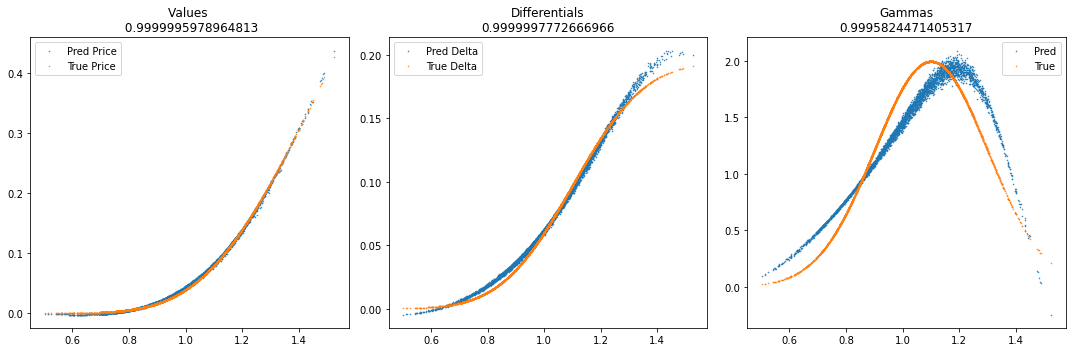

In [94]:
pred = predict(pruned_normalized_model, x_test)
plot_eval(pruned_normalized_model, pred, test_set, "pruned_ml")

In [95]:
from typing import Callable

class PrunedModel(eqx.Module):
    
    params: dict
    f: Callable
    
    def __init__(self, model, params):
        self.params = params
        self.f = model
        
    def __call__(self, x, keys=None):
        return y_denormalizer(self.f(self.params, [x_normalizer(x)])[0].squeeze())
        

In [96]:
eqx_pruned_model = PrunedModel(jax_func, model_params)

In [97]:
eqx.filter_grad(eqx_pruned_model)(x_test[0])

Array([0.01413359, 0.07665853, 0.08313605, 0.08132416, 0.01837742,
       0.03099717, 0.08816608], dtype=float64)

In [98]:
eqx.filter_vmap(eqx.filter_grad(eqx_pruned_model))(x_test)

Array([[0.01413359, 0.07665853, 0.08313605, ..., 0.01837742, 0.03099717,
        0.08816608],
       [0.03148707, 0.17723279, 0.18174001, ..., 0.04641786, 0.06203493,
        0.20089904],
       [0.0235535 , 0.12692119, 0.13256659, ..., 0.03232487, 0.04690953,
        0.14257148],
       ...,
       [0.03119038, 0.17503711, 0.18327314, ..., 0.04536927, 0.06264895,
        0.20205545],
       [0.00592344, 0.02928155, 0.03084092, ..., 0.00734749, 0.01157296,
        0.03191006],
       [0.00825981, 0.04136628, 0.04289903, ..., 0.01064356, 0.01591273,
        0.04465885]], dtype=float64)

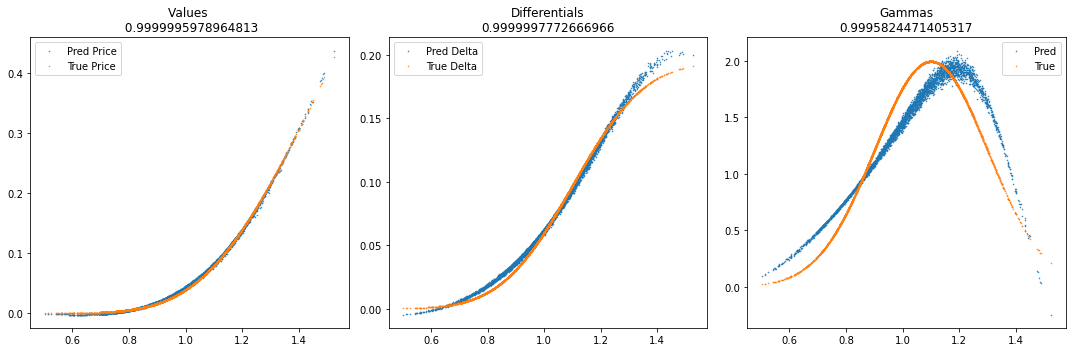

In [100]:
pred = predict(eqx_pruned_model, x_test)
plot_eval(eqx_pruned_model, pred, test_set, "eqx_pruned_ml")

# fine tune model

## regular ML

In [111]:
def bachelier_finetune_pruned_ml(key: Array, model):
    key, subkey = jax.random.split(key)
    num_epochs = 100
    optim = optax.adam(learning_rate=0.0001)
    model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)
    return model

In [114]:
generator_train_ds, generator_test_ds, x_test = gen_data_standard_ml()
key = jrandom.PRNGKey(0)
finetuned_pruned_model = bachelier_finetune_pruned_ml(key, eqx_pruned_model)

Finished epoch   0  | Train Loss: 0.00119  | Test Loss: 0.00265
Finished epoch   1  | Train Loss: 0.00123  | Test Loss: 0.00250
Finished epoch   2  | Train Loss: 0.00138  | Test Loss: 0.00246
Finished epoch   3  | Train Loss: 0.00144  | Test Loss: 0.00250
Finished epoch   4  | Train Loss: 0.00132  | Test Loss: 0.00248
Finished epoch   5  | Train Loss: 0.00160  | Test Loss: 0.00247
Finished epoch   6  | Train Loss: 0.00114  | Test Loss: 0.00245
Finished epoch   7  | Train Loss: 0.00112  | Test Loss: 0.00245
Finished epoch   8  | Train Loss: 0.00141  | Test Loss: 0.00240
Finished epoch   9  | Train Loss: 0.00124  | Test Loss: 0.00240
Finished epoch  10  | Train Loss: 0.00165  | Test Loss: 0.00241
Finished epoch  11  | Train Loss: 0.00148  | Test Loss: 0.00241
Finished epoch  12  | Train Loss: 0.00116  | Test Loss: 0.00239
Finished epoch  13  | Train Loss: 0.00142  | Test Loss: 0.00237
Finished epoch  14  | Train Loss: 0.00166  | Test Loss: 0.00235
Finished epoch  15  | Train Loss: 0.0015

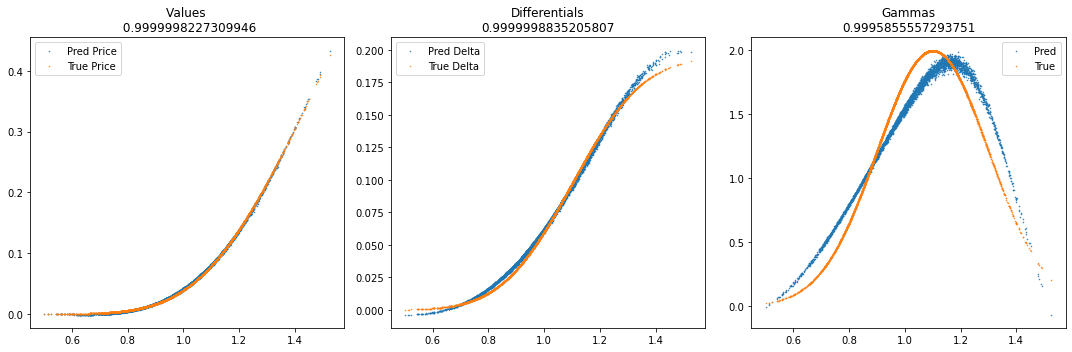

In [115]:
pred = predict(retrained_pruned_model, x_test)
plot_eval(retrained_pruned_model, pred, test_set, "retrained_pruned_ml")

# Diff ML

In [123]:
def bachelier_finetune_pruned_dml(key: Array, model):
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    optim = optax.adam(learning_rate=lr_schedule)
    model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=100)
    return model

In [121]:
generator_train_ds, generator_test_ds, x_test = gen_data_dml()
y_test = prices
key = jax.random.PRNGKey(42)
fine_tuned_pruned_model_dml = bachelier_finetune_pruned_dml(key, eqx_pruned_model)

Finished epoch   0  | Train Loss: 0.00107  | Test Loss: 0.09090
Finished epoch   1  | Train Loss: 0.00102  | Test Loss: 0.09235
Finished epoch   2  | Train Loss: 0.00106  | Test Loss: 0.09346
Finished epoch   3  | Train Loss: 0.00102  | Test Loss: 0.09600
Finished epoch   4  | Train Loss: 0.00097  | Test Loss: 0.09484
Finished epoch   5  | Train Loss: 0.00097  | Test Loss: 0.09353
Finished epoch   6  | Train Loss: 0.00101  | Test Loss: 0.09354
Finished epoch   7  | Train Loss: 0.00098  | Test Loss: 0.09255
Finished epoch   8  | Train Loss: 0.00099  | Test Loss: 0.09271
Finished epoch   9  | Train Loss: 0.00099  | Test Loss: 0.09403
Finished epoch  10  | Train Loss: 0.00104  | Test Loss: 0.09077
Finished epoch  11  | Train Loss: 0.00095  | Test Loss: 0.09420
Finished epoch  12  | Train Loss: 0.00112  | Test Loss: 0.09271
Finished epoch  13  | Train Loss: 0.00107  | Test Loss: 0.09331
Finished epoch  14  | Train Loss: 0.00093  | Test Loss: 0.09206
Finished epoch  15  | Train Loss: 0.0010

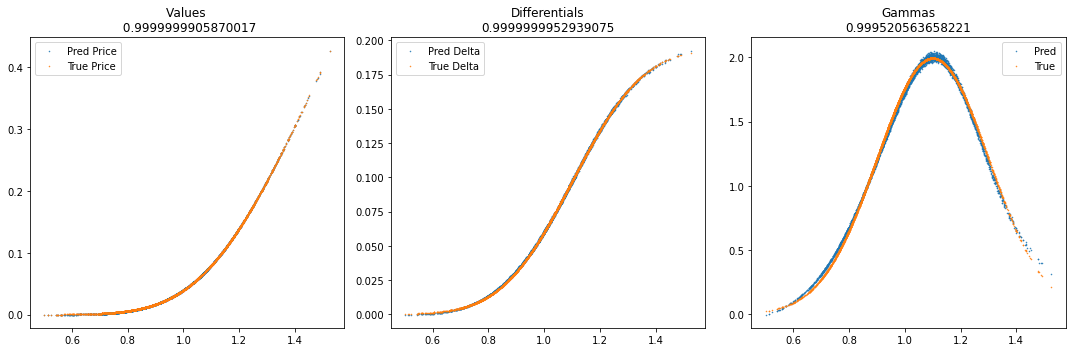

In [122]:
pred = predict(fine_tuned_pruned_model_dml, x_test)
plot_eval(fine_tuned_pruned_model_dml, pred, test_set, "finetuned_pruned_dml")

# Use second-order diff ml

In [134]:
def hvp(f, primals, tangents):
    return jax.jvp(lambda x: eqx.filter_grad(f)(x), primals, tangents)[1]

def hmp(f, primals):
    
    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

def batch_hmp(f):

    def hvp_(primals, tangents):
        return hvp(f, (primals, ), (tangents, ))

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))

def hvp_args(f, primals, tangents, *f_args):
    return jax.jvp(lambda x: eqx.filter_grad(f)(x, *f_args), primals, tangents)[1]

def hmp_args(f, primals, *f_args):
    
    def hvp_(tangents):
        return hvp_args(f, (primals,), (tangents, ), *f_args)

    return eqx.filter_vmap(hvp_)

def batch_hmp_args(f, vmapped_args: Tuple = ()):

    def hvp_(primals, tangents, *f_args):
        return hvp_args(f, (primals, ), (tangents, ), *f_args)

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None, *vmapped_args)), in_axes=(None, 1, *tuple([None for _ in range(len(vmapped_args))])))

# jax cannot deal with dynamic slices of arrays
# therefore, we cannot simply slice the principal_components array while using batch_hmp

# this is a version where a 0 vector principal component will lead to a different path (namely returning 0) compared to computing a hvp.
def cond_fn_pca(tangents, *args):
    # xs, cum_sum = x
    # return cum_sum > 0.95

    # jax.debug.print("tangents {tangents}", tangents=tangents)

    return jnp.any(tangents[0] > 0.0)  # NOTE: we set the tangents to zero if we do not want to compute its derivative (because principle component is too small)

def hvp_pca(f, primals, tangents):
    return jax.lax.cond(cond_fn_pca(tangents), lambda _: hvp(f, primals, tangents), lambda _: tangents[0], None)

def batch_hmp_select(f):

    def hvp_(primals, tangents):
        return hvp_pca(f, (primals,), (tangents,))

    # x = jnp.zeros(shape=(1, 1))
    # jax.lax.while_loop(cond_fn_pca, fn, (x, 0.0)) # not reverse-mode differentiable!
    # jnp.piecewise(x, cond_fn_pca, fn, (x, 0.0)) # not reverse-mode differentiable!

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))

# this is a version where we explicitly add a list of boolean values, indicating whether we should compute the hvp or not
def hvp_conditional(f, primals, tangents, eval_hvp):
    # jax.debug.print("primals {x}", x=primals)
    # jax.debug.print("tangents {x}", x=tangents)
    # jax.debug.print("eval_hvp {x}", x=eval_hvp)

    # jax.lax.cond(eval_hvp, lambda _: jax.debug.print("using hvp: {eval}", eval=eval_hvp), lambda _: jax.debug.print("not using hvp: {eval}", eval=~eval_hvp), None)

    # res = hvp(f, primals, tangents)
    # jax.debug.print("evalhvp.shape {res}", res=res.shape)
    return jax.lax.cond(eval_hvp, lambda _: hvp(f, primals, tangents), lambda _: jnp.zeros(shape=(primals[0].shape[-1],)), None)

def batch_hmp_cond(f):

    def hvp_(primals, tangents, eval_hvp):
        return hvp_conditional(f, (primals,), (tangents,), eval_hvp)

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None, None)), in_axes=(None, 1, 0))

In [135]:
class LossState(eqx.Module):
    loss_history = np.zeros((4, 100))
    losses: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    lambdas: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    initial_losses: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    accum_losses: Float[Array, "n_losses"] = jnp.zeros(3)
    prev_mean_losses: Float[Array, "n_losses"] = jnp.zeros(3)
    current_iter: Float[Array, "n_losses"] = jnp.zeros(3)

    def update_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(new_value, state.lambdas, state.initial_losses, state.accum_losses, state.prev_mean_losses, state.current_iter)

    def update_lambdas(state, new_value: Float[Array, "n_losses"]):# -> LossState:
        return LossState(state.losses, new_value, state.initial_losses, state.accum_losses, state.prev_mean_losses,  state.current_iter)
        
    def update_initial_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, new_value, state.accum_losses, state.prev_mean_losses,  state.current_iter)
        
    def update_accum_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, new_value, state.prev_mean_losses,  state.current_iter)
        
    def update_current_iter(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, state.accum_losses, state.prev_mean_losses,  new_value)

    def update_prev_mean_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, state.accum_losses, new_value,  state.current_iter)

    def __repr__(self):
        return "LossState"

In [136]:
from enum import Enum

class dydx_type(Enum):
    Default = 1
    MeanAdjusted = 2
    PCA = 3
    PCA_Reduced = 4


def plot_singular_values(S):
    plt.title("Singular Values of Gradient")
    plt.plot(S, 'r', markersize=0)
    plt.show()


def plot_dydx_pred(x, dydx_pred, title):
   
    if title == dydx_type.Default.value:
        plt.title("Predicted Gradients of all Dimensions")
    elif title == dydx_type.MeanAdjusted.value: 
        plt.title("Predicted Gradients of all Dimensions | Mean Adjusted")
    elif title == dydx_type.PCA.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reconstruction")
    elif title == dydx_type.PCA_Reduced.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reduced")
    else:  
        plt.title("Predicted Gradients of all Dimensions")

    for i in range(dydx_pred.shape[1]):
        plt.plot(x[:, i], dydx_pred[:, i], '.', markersize=1)
    plt.show()

colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray']

def plot_dydx_pred_individual_dims(x, dydx, dydx_pred, dydx_pred_pca, principal_components, pc_scaled):

    for i in range(x.shape[1]):

        plt.title(f"Differentials Dimension {i}")
        plt.plot(x[:, i], dydx[:, i], 'r.', markersize=1, label="True")
        plt.plot(x[:, i], dydx_pred[:, i], 'b.', markersize=1, label="Pred")
        plt.legend()
        plt.show()

        # variance within the dimesions:
        plt.title(f"Variance of Dim {i} (y-axis) w.r.t Dim 0 (x-axis))")
        plt.plot(dydx_pred_pca[:, 0], dydx_pred_pca[:, i], 'b.', markersize=1)

        for j, _ in enumerate(principal_components):
            plt.plot(np.array([0, 0 + pc_scaled[j, 0]]),
                    np.array([0,  0 + pc_scaled[j, i]]), '-',  color=colors[j % len(colors)], linewidth=5, label=f"PC{j}")

        plt.legend()
        plt.show()


# def plot_ddyddx(x, ddyddx):
#   plt.title("Gammas ")
#   dydx_idx = 0
#   for i in range(x_test.shape[1]):
#     for j in range(x_test.shape[1]):
#       plt.plot(baskets, pred_ddyddx[:, i, j], '.', markersize=1, label=f"Gamma {i},{j}")
#   plt.legend(loc='upper left')
#   plt.show()


def plot_ddyddx_pred(x, ddyddx):
  for i in range(x.shape[1]):
    plt.title(f"2nd-Order Differential Predictions {i}")

    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j % len(colors)], label=f"ddyddx {i},{j}")
    plt.show()


def plot_ddyddx_pred_hvp(x, ddyddx):
  plt.title(f"2nd-Order Differential HVP Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd(x, ddyddx):
  plt.title(f"2nd-Order Finite-Difference Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd_of_grad(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_grad_full(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Full Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_fd(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over FD Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()


def plot_hesse_model_vs_data(x, hesse_model, hesse_data):
  plt.title(f"Hesse Model vs Data")

  # for now we only consider one dimension
  for i in range(x.shape[-1]):
    lines_x = jnp.array([x[:, i], x[:, i]])
    lines_y = jnp.array([hesse_model[:, i, 0], hesse_data[:, i, 0]])
    plt.plot(lines_x, lines_y, c='lightgray')
    plt.plot(x[:, i], hesse_model[:, i, 0], '.', c='blue', markersize=3, label=f"hesse model")
    plt.plot(x[:, i], hesse_data[:, i, 0], '.', c='red', markersize=3, label=f"hesse data")
  plt.show()


def plot_ddyddx_pred_all(x, data_dict, n_dims):
  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, (title, ddyddx) in enumerate(data_dict.items()):
    for i in range(ddyddx.shape[1]):
      for j in range(ddyddx.shape[-1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(title)
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()


def plot_ddyddx_pred_cond(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['hmp_pc_cond (model)', 'ddpayoff_cond (model)', 'hmp_pc (model)', 'ddpayoff (model)']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(ddyddx.shape[1]):
      for j in range(ddyddx.shape[-1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()

def plot_ddyddx_pc_reduced(x, hmp_pc, hmp_pc2):

  fig, axs = plt.subplots(1, 3)
    
  plt.title(f"2nd-Order Differentials w/ Reduced PC")
  axs[0].set_title("hmp_pc (truncated)")
  axs[1].set_title("hmp_pc2")
  
  for i in range(hmp_pc2.shape[1]):
    for j in range(hmp_pc2.shape[-1]):
      axs[0].plot(x[:, i], hmp_pc[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
      axs[1].plot(x[:, i], hmp_pc2[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  axs[2].set_title("hmp_pc (full)")

  for i in range(hmp_pc.shape[1]):
    for j in range(hmp_pc.shape[-1]):
      axs[2].plot(x[:, i], hmp_pc[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()
    

def plot_ddyddx_pred_hess_compare(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['selected_hvp', 'hmp_pc', 'hmp_res', 'hessian']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(x.shape[-1]):
      for j in range(ddyddx.shape[1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()


def plot_batch(x, y, y_pred):
    plt.title("Data Batch Normalized")
    plt.plot(x, y, 'r.', markersize=1)
    plt.plot(x, y_pred, 'b.', markersize=1)
    plt.show()


def plot_batch_delta(x, y_delta):
    plt.title("Data Batch Delta")
    plt.plot(x, y_delta, 'b.', markersize=1)
    plt.show()


def print_ddpayoff(ddpayoff):
    nnz = ddpayoff != 0.
    ddpayoff_nnz = ddpayoff[nnz]
    print("ddpayoff: ", ddpayoff_nnz)
    
  
def print_k_pc(pc, k_pc):
  print("pc: ", pc[k_pc:, :])


In [203]:
def diff_pca_loss_fn(model: eqx.nn.MLP, loss_state: LossState, x: Float[Array, "batch"], inc1: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"], key, debug: bool = True) -> Float:
    kappa = 0.95
    
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # because of pca the number of 2nd order differential data computed will not be the full hessian. Thus eta is smaller than 1 to account for this.
    # I guess it should ideally be k/n with k being the number of important dimensions (i.e., they cannot be reduced by pca). For bachelier, we know
    # that this is only 1 dimenions.
    n_important_dims = 1
    eta = (n_important_dims/n_dims) ** 2
    alpha = eta * alpha
    beta = eta * beta
    gamma = 1 - alpha - beta # NOTE: we could use the magnitue of the principle components to set this value
    
    if 1:
        scale = (1 + lam * n_dims + eta * n_dims * n_dims)
        alpha = 1 / scale
        beta = (lam * n_dims) / scale
        gamma = 1.0 - alpha - beta
        beta = 1.0 - alpha - gamma

    if 0:
        alpha = 0.2
        gamma = 0.2
        beta = 1.0 - alpha - gamma

    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)

    #
    # full hessian matrix
    #
    hess = jax.hessian(model)
    hessian = eqx.filter_vmap(hess)(x)
    # jax.debug.print("Hessian: {H}", H=hessian.shape)
    
    #
    # hessian with custom batch_hmp
    #
    batch_hmp_fn = batch_hmp(model)
    basis = jnp.eye(x.shape[-1], dtype=x.dtype)
    hmp_res = batch_hmp_fn(x, basis)
    hmp_res = jnp.transpose(hmp_res, (1, 0, 2))

    y_pred = y_pred[..., jnp.newaxis]
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)

    #
    # Compute PCA
    #
    if 1:
        dydx_pred_means = jnp.mean(dydx_pred, axis=0)
        # print("dydx_pred_means.shape:", dydx_pred_means.shape)
        # jax.debug.print("dydx_pred_means: {}", dydx_pred_means)

        tiled_dydx_pred_means = jnp.tile(dydx_pred_means, (dydx_pred.shape[0], 1))
        dydx_pred_mean_adjusted = dydx_pred - tiled_dydx_pred_means

        U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)
    elif 0:
        # Alternative approach: Use the difference of dydx_pred and dydx to get the principle components
        dydx_diff = dydx_pred - dydx
        dydx_pred_means = jnp.mean(dydx_diff, axis=0)
        dydx_pred_mean_adjusted = dydx_diff - jnp.tile(dydx_pred_means, (dydx_diff.shape[0], 1))
        U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)
    else:
        # what if we take the dydx labels instead of the dydx_pred labels?
        dydx_mean = jnp.mean(dydx, axis=0)
        dydx_pred_mean_adjusted = dydx - jnp.tile(dydx_mean, (dydx.shape[0], 1))
        U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)

    # the principal components give use the directions for the hesse vectors
    principal_components = jnp.diag(S) @ VT
    # principal_components += dydx_pred_means
    
    # singular values scaled to represent % of variance explained.
    S_var = S**2 / jnp.sum(S**2)
    
    # find index k, s.t. the first k elements in S_var account for 95% of the variance
    k_pc = jnp.argmax(jnp.cumsum(S_var) > kappa) # returns first occurence of True
    k_pc = jnp.maximum(k_pc, jnp.ones_like(k_pc))

    def batch_hmp_single_tangent(f, primals):
    
        def hvp_(primals, tangents):
            return hvp(f, (primals,), (tangents,))
    
        return partial(eqx.filter_vmap(hvp_, in_axes=(0, None)), primals)

    # TODO: having input data x coupled is probably not a good idea. We want to reuse the same while_fn for every iteration.
    #       So make input data a parameter to while_fn as well.
    single_hvp_fn = batch_hmp_single_tangent(model, x)
    
    def while_fn(tup):
        x, pc, mtx = tup
        # jax.debug.print("current x = {x}", x=x)
        # jax.debug.print("mtx.shape is {mtx}", mtx=mtx.shape)
        test = single_hvp_fn(pc[x, :].T)
        # jax.debug.print("test.shape is {ts}", ts=test.shape)
        mtx = mtx.at[:, x, :].set(test)
        # jax.debug.print("mtx is {mtx}", mtx=mtx)
        
        return x - 1, pc, mtx
        
    _, _, mtx = jax.lax.while_loop(lambda tup: tup[0] >= 0, while_fn, (x.shape[1], principal_components, jnp.zeros(shape=(x.shape[0], x.shape[1], x.shape[1]))))

    #
    # Compute hmp_pc_cond
    #
    
    compute_hvp = ~(jnp.cumsum(S_var) > kappa)
    # if the first principal component is already accounting for 95% of the variance, compute_hvp will be just all False.
    # Below we make use that at least the first principal component is always actively used.
    compute_hvp = compute_hvp.at[0].set(True)
    
    # jax.debug.print("compute_hvp: {v}", v=compute_hvp)
    # compute_hvp = jnp.array([True]*7)
    # compute_hvp = jnp.array([True, True, False, False, False, False, False])
    batch_hmp_cond_fn = batch_hmp_cond(model)
    hmp_pc_cond = batch_hmp_cond_fn(x, principal_components.T, compute_hvp)
    hmp_pc_cond = jnp.transpose(hmp_pc_cond, (1, 0, 2))

    #
    # For comparison: Use a random selection of principal components
    #
    key, subkey = jax.random.split(key)
    pc_rand_selection = jax.random.bernoulli(key, shape=compute_hvp.shape)
    hmp_pc_rand_cond = batch_hmp_cond_fn(x, principal_components.T, pc_rand_selection)
    hmp_pc_rand_cond = jnp.transpose(hmp_pc_rand_cond, (1, 0, 2))


    #
    # For comparison: Use a random selection of exactly k_pc principal components
    #
    n_pc = principal_components.shape[0]
    l_pc = 2 # (jnp.sqrt(n_pc)).astype(jnp.int64)
    pc_indices = jnp.linspace(0, n_pc - 1, n_pc, dtype=jnp.int64)
    pc_k_selection = jnp.zeros_like(compute_hvp)
    k_rand_bools = jax.random.choice(key, pc_indices, shape=(l_pc,), replace=False)
    pc_k_selection = pc_k_selection.at[k_rand_bools].set(True)
    hmp_pc_k_rand_cond = batch_hmp_cond_fn(x, principal_components.T, pc_k_selection)
    hmp_pc_k_rand_cond = jnp.transpose(hmp_pc_k_rand_cond, (1, 0, 2))

    if debug:
      jax.debug.print("hmp_pc_cond.shape {pc}", pc=hmp_pc_cond.shape)
      jax.debug.print("compute_hvp {hvp}", hvp=compute_hvp)
     
      jax.debug.print("Singluar Values: {S}", S=S)

      jax.debug.print("Singluar Values Variance Explained: {S}", S=S_var)
      jax.debug.print("k_pc: {k_pc}", k_pc=k_pc)
      # jax.debug.print("k_pc.dtype: {k_pc}", k_pc=k_pc.dtype)


      # jax.debug.print("pc.shape[0]: {pc}", pc=principal_components.shape[0])

      # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, k_pc, axis=0)
      # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, k_pc, axis=0)
      # first_k_pc = jax.lax.dynamic_slice(principal_components, (0, 0), (2, 2))

      jax.debug.print("pc {pc}", pc=principal_components)
      # jax.debug.print("first k pc {pc}", pc=principal_components[:k_pc, :])
      # print("first k pc: ", first_k_pc)

      # hvp_first_k_pc = principal_components[:2, :] @ hessian
      # jax.debug.print("hvp_first_k_pc {hvp}", hvp=hvp_first_k_pc)

    # NOTE: The principle component directions could have a factor -1 that deviates from the desired direction (e.g., vector points north instead of south in 2D case).
    #       We need to check for that and flip the sign of the principle component if necessary.
    #       This can be decided using the dydx target data.
    #       -> not an issue if we consider pc @ hessian

    # TODO: Think about the implications and whether to do this per dimension or per batch
    #       For now we do it per dimension



    # now instead of computing the hessian seperately from the identity matrix
    # we directly use the principle components

    # jax.debug.print("basis.shape {basis}", basis=basis.shape)
    # jax.debug.print("principal_components.shape {pc}", pc=principal_components.shape)

    #
    # Compute hmp with all principal components
    #
    hmp_pc = batch_hmp_fn(x, principal_components.T)
    hmp_pc = jnp.transpose(hmp_pc, (1, 0, 2))

    #
    # compute hmp with random set of vectors
    #
    # similar approach to https://arxiv.org/ftp/arxiv/papers/1206/1206.6464.pdf
    #    
    n_dim = x.shape[-1]
    key, subkey = jax.random.split(key)
    # rand_vectors = jax.random.uniform(subkey, shape=(n_dim, n_dim), minval=0.0, maxval=1.0)

    # rand_vectors = jax.random.bernoulli(subkey, shape=(n_dim, n_dim)).astype(jnp.float64)

    # print("rand_vectors {}", rand_vectors.shape)

    n_rand_vectors = n_dim
    rand_vectors = jax.random.multivariate_normal(subkey, jnp.zeros(shape=(n_dim, )), jnp.eye(n_dim))#, shape=(n_rand_vectors,))
    rand_vectors = jnp.outer(rand_vectors, rand_vectors)
    
    # rand_vectors = jax.random.normal(subkey, shape=(n_dim, n_dim))
    hmp_rand = batch_hmp_fn(x, rand_vectors)
    hmp_rand = jnp.transpose(hmp_rand, (1, 0, 2))

    
    # jax.debug.print("hmp_pc.shape {shape}", shape=hmp_pc.shape)
    
    hmp_pc2 = batch_hmp_fn(x, principal_components[:2, :].T)
    hmp_pc2 = jnp.transpose(hmp_pc2, (1, 0, 2))
    # jax.debug.print("hmp_pc2 vs hmp_pc_cond {diff}", diff= jnp.sum(hmp_pc2 - hmp_pc_cond))

    if debug:
        jax.debug.print("hmp_pc2.shape {shape}", shape=hmp_pc2.shape)
        # jax.debug.print("----------\nhmp_pc2 {pc}", pc=hmp_pc2)

    # jax.debug.print("pc2 {pc}", pc=principal_components[:2, :])

    # direction_signs = jnp.sign(jnp.sum(dydx * principal_components, axis=1))


    # we need the vjp_fun from eqx.filter_vjp 
    # then we can *hopefully* use eqx.filter_vjp(vjp_fun, principal_components) 
    # to get to selected hvp results. Those can then be used as part of the loss  

    partial_vjp = partial(eqx.filter_vjp, model)
    y_pred_vjp, vjp_fun = vmap(partial_vjp)(x)

    # jax.debug.print("function is: {fn}", fn=vjp_fun)
    # test_values = vmap(vjp_fun)(jnp.ones_like(y_pred_vjp))
    # jax.debug.print("test values = {tv}", tv=test_values)

    y_pred_vjp = y_pred_vjp[..., jnp.newaxis]

    # jax.debug.print("y_pred={y}", y=y_pred)
    # jax.debug.print("y_pred_vjp={y}", y=y_pred_vjp)
    # jax.debug.print("MSE(y_pred, y_pred_vjp) = {res}", res=mse(y_pred, y_pred_vjp))
    # chex.assert_trees_all_close(y_pred, y_pred_vjp)


    # jax.debug.print("shape must be: {shape}", shape=y_pred_vjp.shape)
    # jax.debug.print("but we have: {shape}", shape=x.shape)
    # dydx_pred_vjp, hvp_fun = vmap(partial(eqx.filter_vjp, vjp_fun))(x)


    # basis = jnp.eye(y_pred_vjp.size, dtype=y.dtype)
    # jac = vmap(vjp_fun)(basis)[0] 

    # ---

    # jax.debug.print("Hessian shape {H}", H=hessian.shape)
    # jax.debug.print("Principle components shape: {PC}", PC=principal_components.shape)

    # generate the missing second-order differential training data which 
    # depends on the principle components.

    # Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    D_payoff = jax.vmap(jax.grad(payoff))
    payoff_nonsmooth = True
    if payoff_nonsmooth:
    
        def cfd(f, h, x, *args):
    
          def cfd_(v):
            xph = x + h * v 
            xmh = x - h * v 
            fd_of_f = (f(xph, *args) - f(xmh, *args)) / (2 * h)
            # jax.debug.print("fd_of_f = {fd}", fd=fd_of_f)
    
            # fd_of_f = vmap(jnp.multiply)(fd_of_f, jnp.sign(v))
            # fd_of_f = jnp.multiply(fd_of_f, jnp.sign(v))
            # jax.debug.print("fd_of_f_after = {fd}", fd=fd_of_f)
    
            # jax.debug.print("shape of v: {v}", v=v.shape)
            # jax.debug.print("fd_of_f.shape: {fd}", fd=fd_of_f.shape)
            return fd_of_f
    
          return cfd_
    
        def batch_cfd_of_dpayoff_conditional(f):
            def cfd_of_dpayoff_conditional(tangent, eval_hvp):
                return jax.lax.cond(eval_hvp, lambda t: f(t), lambda t: jnp.zeros_like(x), tangent)
                
            return eqx.filter_vmap(cfd_of_dpayoff_conditional, in_axes=(0, 0))
    
        def optimal_step(x: Float):
            h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
            return h * jnp.fabs(x)
    
        # for now consider fixed h
        # h = optimal_step(jnp.mean(x))
        # h = 5e-2
    
        # TODO: Maybe h should depend on the dimensionality of the problem?
        # h = 1e-1
        h = 1e-1
        
        # jax.debug.print("h = {h}", h=h)
        eye = jnp.eye(n_dims)
        basis = eye * h
        v = principal_components[0] 
        # jax.debug.print("v : {v}", v=v)
    
        # jax.debug.print("x : {x}", x=x)
    
        xph = x + h * v
        # jax.debug.print("xph : {xph}", xph=xph)
        xmh = x - h * v
        # jax.debug.print("xmh : {xmh}", xmh=xmh)
    
        fd_xph = D_payoff(xph, inc1)
        # jax.debug.print("fd_xph : {fd}", fd=fd_xph)
        fd_xmh = D_payoff(xmh, inc1)
        # jax.debug.print("fd_xmh : {fd}", fd=fd_xmh)
        fd_of_dpayoff = (D_payoff(xph, inc1) - D_payoff(xmh, inc1)) / (2 * h)
        # jax.debug.print("fd of payoff: {fd}", fd=fd_of_dpayoff)
        # jax.debug.print("mean of fd of payoff: {fd}", fd=jnp.mean(fd_of_dpayoff, axis=0))
        # jax.debug.print("fd of payoff: {fd}", fd=fd_of_dpayoff)
        
        cfd_of_dpayoff_fn = cfd(D_payoff, h, x, inc1)
        cfd_of_dpayoff = vmap(cfd_of_dpayoff_fn)
        # ddpayoff = cfd_of_dpayoff(principal_components[:2, :])
        ddpayoff = cfd_of_dpayoff(principal_components)
        ddpayoff = jnp.transpose(ddpayoff, (1, 0, 2))
        # ddpayoff = jnp.abs(ddpayoff)
    
        test_cfd = cfd_of_dpayoff_fn(principal_components[0])
        # jax.debug.print("testcfd = {cfd}", cfd=test_cfd.shape)
    
        cfd_of_dpayoff_cond = batch_cfd_of_dpayoff_conditional(cfd_of_dpayoff_fn)
        ddpayoff_cond = cfd_of_dpayoff_cond(principal_components, compute_hvp)
        ddpayoff_cond = jnp.transpose(ddpayoff_cond, (1, 0, 2))

        #
        # For comparison: Use random directions.
        #
        ddpayoff_rand = cfd_of_dpayoff(rand_vectors)
        ddpayoff_rand = jnp.transpose(ddpayoff_rand, (1, 0, 2))

        #
        # For comparison: Use random selection of principal components.
        #
        ddpayoff_cond_pc_rand_selection = cfd_of_dpayoff_cond(principal_components, pc_rand_selection)
        ddpayoff_cond_pc_rand_selection = jnp.transpose(ddpayoff_cond_pc_rand_selection, (1, 0, 2))

        #
        # For comparison: Use random selection of k principal components.
        #
        ddpayoff_cond_pc_k_rand_selection = cfd_of_dpayoff_cond(principal_components, pc_k_selection)
        ddpayoff_cond_pc_k_rand_selection = jnp.transpose(ddpayoff_cond_pc_k_rand_selection, (1, 0, 2))
        
    else: # payoff is smooth -> apply regular AD
        pass

    #
    # Compute gammas using (full hessian) ad 
    #
    
    ddpayoff_hessian = jax.vmap(jax.hessian(payoff, argnums=0))(x, inc1)

    #
    # Compute gammas using (fwd_over_rev) ad
    #

    def jmp(D_f, x, *args, **kwargs):

        # we need to batch this as well
        def jvp_(v):
            return jax.jvp(lambda x_: D_f(x_, *args, **kwargs), (x, ), (v, ))
    
        return jax.vmap(jvp_)

    jmp_ = jmp(D_payoff, x, inc1)

    k_samples = x.shape[0]
    n_dim = x.shape[-1]
    seed = jnp.eye(n_dim) 
    rep_seed = jnp.repeat(seed, k_samples, axis=0)
    rep_seed = jnp.reshape(rep_seed, (n_dim, k_samples, n_dim))

    ddpayoff_fwd = jmp_(rep_seed)
    ddpayoff_fwd = jnp.transpose(ddpayoff_fwd[1], (1, 0, 2))

    if debug:
        is_allclose = jnp.allclose(ddpayoff_hessian, ddpayoff_fwd)
        jax.debug.print("is allclose {}", is_allclose)

    #
    # Using batch_hmp
    #

    ddpayoff_hmp = batch_hmp_args(payoff, (0, ))(x, seed, inc1)
    ddpayoff_hmp = jnp.transpose(ddpayoff_hmp, (1, 0, 2))
    
    #
    # Using principal components for the hesse vector directions
    #
    ddpayoff_hmp_pc = batch_hmp_args(payoff, (0, ))(x, principal_components.T, inc1)
    ddpayoff_hmp_pc = jnp.transpose(ddpayoff_hmp_pc, (1, 0, 2))

    # NOTE: we cannot partial with inc1 since it will have to be vmapped over alongside the x matrix
    # payoff_ad = partial(payoff, inc1=inc1)
    # payoff_data = payoff_ad(x)[:, jnp.newaxis]
    # jax.debug.print("payoff data: {data}", data=payoff_data.shape)
    # jax.debug.print("y data: {data}", data=y.shape)
    # jax.debug.print("y-payoff_ad ={delta}", delta=y - payoff_data)

    
    
    # basis = jnp.eye(x.shape[-1], dtype=x.dtype)
    # ddpayoff_ad_res = ddpayoff_ad_fn(x, basis)

    # jax.debug.print("shape of ddpayoff: {ddp}", ddp=ddpayoff.shape)
    # jax.debug.print("ddpayoff: {fd}", fd=ddpayoff)

    # jax.debug.print("-" * 40)
    # jax.debug.print("principal components: {pc}", pc=principal_components)
    # jax.debug.print("first principal components: {pc}", pc=principal_components[0])

    selected_hvp = principal_components @ hmp_res
    if debug:
      jax.debug.print("Selected HVP shape: {hvp}", hvp=selected_hvp.shape)
      # jax.debug.print("Selcted HVP: {hvp}", hvp=selected_hvp)

      # compute second order central finite differences of model
      h = 1e-4
      fdd_x = x
      grad_model = vmap(eqx.filter_grad(model))

      # here we directly perturbe all values of fdd_x. I think we need to do
      # this on a per element basis
      xph = fdd_x + h
      xmh = fdd_x - h
      fdd_xph = grad_model(xph)
      fdd_xmh = grad_model(xmh)
      fd_of_grad = (fdd_xph - fdd_xmh) / (2 * h)

      fd_of_fd_xph = vmap(model)(xph)
      fd_of_fd_xmh = vmap(model)(xmh)
      fd_of_fd = (fd_of_fd_xph - 2 * y_pred + fd_of_fd_xmh) / (h * h)

      def fd_row(i):
          xph = fdd_x.at[:, i].set(fdd_x[:, i] + h)
          xmh = fdd_x.at[:, i].set(fdd_x[:, i] - h)
  
          fdd_xph = grad_model(xph)
          fdd_xmh = grad_model(xmh)
          fdd_i = (fdd_xph - fdd_xmh) / (2 * h) 
          return fdd_i

      fd_of_grad_full = jnp.transpose(jnp.array([fd_row(i) for i in range(x.shape[-1])]), (1, 0, 2))

      hessian_data = jnp.zeros_like(hessian)
      jax.debug.print("FD_of_grad shape: {fd}", fd=fd_of_grad.shape)
      jax.debug.print("FD_of_grad_full shape: {fd}", fd=fd_of_grad_full.shape)
      jax.debug.print("FD_of_FD shape: {fd}", fd=fd_of_fd.shape)
      jax.debug.print("hessian shape: {fd}", fd=hessian.shape)

      pc_scaled = principal_components / jnp.sqrt(x.shape[0])
      dydx_pred_pca = U @ principal_components
      k_dims = 1
      dydx_pred_reduced = U[:, :k_dims] @ principal_components[:k_dims, :]

      pca_reconstruction_err = mse(dydx_pred_mean_adjusted, dydx_pred_pca)
      jax.debug.print("pca reconstruction_err: {err}", err=pca_reconstruction_err)

      reduced_reconstruction_err = mse(dydx_pred_mean_adjusted, dydx_pred_reduced)
      jax.debug.print("reduced ({dim} dims) reconstruction_err: {err}", dim=k_dims, err=reduced_reconstruction_err)

      # TODO: Still need to figure out how to use chex in the context of a jitted eqx function. NOTE: eqx now has custom functions for this
      # chex.assert_trees_all_close(dydx_pred_pca, dydx_pred_mean_adjusted)

      # print("sanity checks")
      I = jnp.eye(VT.shape[0], U.shape[1])
      UU = U.T @ U
      # print("U.T @ U = ", UU)
      # print("shapes: I: ", I.shape)
      # print("shapes: UU: ", UU.shape)

      # chex.assert_trees_all_close(UU, I)

      chex.assert_rank(UU, 2)
      chex.assert_rank(VT, 2)

      chex.assert_shape(UU, I.shape)
      chex.assert_shape(VT, I.shape)
      # chex.assert_shape(UU.shape, I.shape)
      # assert(jnp.allclose(UU, I, atol=1e-06))
      VV = VT @ VT.T
      # print("V.T @ V = ", VV)
      chex.assert_shape(VV, I.shape)

      # jax.debug.print("VT: {VT}", VT=VT)
      # jax.debug.print("Principle Components: {pc}", pc=pc_scaled)

      # result_shape = jax.ShapeDtypeStruct(S.shape, S.dtype)
      # jax.pure_callback(plot_singular_values, result_shape, S)

      # jax.debug.callback(plot_singular_values, S)

      # jax.debug.callback(plot_dydx_pred, x, dydx_pred, dydx_type.Default.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.MeanAdjusted.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA_Reduced.value)
      # jax.debug.callback(plot_dydx_pred_individual_dims, x, dydx, dydx_pred, dydx_pred_pca, principal_components, pc_scaled)

      # jax.debug.callback(plot_ddyddx_pred, x, selected_hvp)
      
      # jax.debug.callback(plot_ddyddx_pred_hvp, x, selected_hvp)
      # jax.debug.callback(plot_ddyddx_fd, x, fdd)
      # jax.debug.callback(plot_ddyddx_fd_of_grad, x, fd_of_grad)
      # jax.debug.callback(plot_ddyddx_fd_of_grad_full, x, fd_of_grad_full)
      # jax.debug.callback(plot_ddyddx_fd_of_fd, x, fd_of_fd)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=jnp.allclose(hessian, fd_of_grad_full))

      # jax.debug.print("res: {}", res)
      jax.debug.callback(plot_ddyddx_pred_all, x, {'hmp_pc': hmp_pc, 'ddpayoff': ddpayoff, 'hessian': hessian, 'fd_of_grad_full': fd_of_grad_full}, x.shape[-1])
      jax.debug.callback(plot_ddyddx_pred_all, x, {'hmp_pc': hmp_pc, 'ddpayoff_hessian': ddpayoff_hessian, 'hessian': hessian, 'ddpayoff_hmp_pc': ddpayoff_hmp_pc}, x.shape[-1])
      
      jax.debug.callback(plot_ddyddx_pred_cond, x, hmp_pc_cond, ddpayoff_cond, hmp_pc, ddpayoff, x.shape[-1])
      jax.debug.callback(plot_ddyddx_pc_reduced, x, hmp_pc, hmp_pc2)
      # jax.debug.callback(plot_ddyddx_pred_hess_compare, x, selected_hvp, hmp_pc, hmp_res, hessian, x.shape[-1])
      jax.debug.callback(plot_ddyddx_pred_all, x, {'hessian @ pc': selected_hvp, 'hmp_pc': hmp_pc, 'hmp': hmp_res, 'hessian': hessian}, x.shape[-1])


      jax.debug.callback(plot_ddyddx_pred_all, x, {'H: pc @ ddpayoff_hessian': principal_components @ ddpayoff_hessian, 'ddpayoff_hmp_pc': ddpayoff_hmp_pc, 'ddpayoff_hmp': ddpayoff_hmp, 'H: ddpayoff_hessian': ddpayoff_hessian}, x.shape[-1])

      # jax.debug.callback(plot_ddyddx_pred_all, x, selected_hvp, ddpayoff, hmp_pc, hessian, x.shape[-1])
      # jax.debug.callback(plot_hesse_model_vs_data, x, selected_hvp, ddpayoff)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=mse(hessian, fd_of_grad_full))
      # jax.debug.print("Principle Components: {pc}", pc=principal_components)
      # jax.debug.print("ddpayoff.shape = {shape}", shape=ddpayoff.shape)

      # jax.debug.callback(plot_batch, x, y, y_pred)
      # jax.debug.callback(plot_batch_delta, x, y - y_pred)


      # chex.assert_trees_all_close(UU, I)
      # jax.experimental.checkify.check(jnp.allclose(UU, I, atol=1e-6), "Identity not fulfilled")

      # identities(UU, I)
      # print("S = ", S)
      # print("Pc.shape: ", pc_scaled.shape)
      # print("Principle components")

      # plt.title("Singular Values of Gradient")
      # plt.plot(S, 'r', markersize=0)
      # plt.show()

    # PCA dependent loss weights
        
    # NOTE: An appropriate eta is crucial for a working second-order method
    eta = (k_pc / n_dims) ** 2
    # eta = (1 / n_dims) ** 2
    # eta = 1
    # jax.debug.print("eta is {eta}", eta=eta)
    scale = (1 + lam * n_dims + eta * n_dims * n_dims)
    alpha = 1 / scale
    beta = (lam * n_dims) / scale
    gamma = 1.0 - alpha - beta

    # jax.debug.print("alpha, beta, gamma before {}", loss_state.lambdas)
    
    if 0:
        alpha = 0.2
        gamma = .2
        beta = .6

    if 0:
        alpha = 0.0
        gamma = 1.0
        beta  = 0.0
    #print(f"loss alpha = {alpha:.3f}, beta = {beta:.3f}, gamma = {gamma:.3f}")
    # jax.debug.print("loss alpha = {a}, beta = {b}, gamma = {g}", a=alpha, b=beta, g=gamma)

    value_loss = jnp.mean((y_pred - y)**2)
    grad_loss = jnp.mean((dydx_pred - dydx)**2)
    
    
    # hessian_loss = jnp.mean((selected_hvp - ddpayoff)**2)
    # hessian_loss = jnp.mean((hmp_pc2 - ddpayoff)**2)
    # hessian_loss = jnp.mean((mtx - ddpayoff)**2)
    # hessian_loss = jnp.mean((hessian - ddpayoff)**2)


    hessian_loss = jnp.mean((hmp_pc - ddpayoff)**2)
    
    # hessian_loss = jnp.mean((hmp_pc_cond - ddpayoff_cond)**2)

    # hessian_loss = jnp.mean((hessian - ddpayoff_hessian)**2)
    # hessian_loss = jnp.mean((hmp_pc - ddpayoff_hmp_pc)**2)

    #
    # Random Vectors
    #

    #
    # Random selection of vectors
    #
    # hessian_loss = jnp.mean((hmp_rand - ddpayoff_rand)**2)

    #
    # Random selection of principal components
    #
    # hessian_loss = jnp.mean((hmp_pc_rand_cond - ddpayoff_cond_pc_rand_selection)**2)

    #
    # Random selection of k principal components
    #
    # hessian_loss = jnp.mean((hmp_pc_k_rand_cond - ddpayoff_cond_pc_k_rand_selection)**2)

    
    
    prev_loss_state = loss_state
    losses = jnp.array([value_loss, grad_loss, hessian_loss])
    
    #
    # Adaptive balancing based on previous loss
    #

    d_loss = jnp.abs(loss_state.losses - prev_loss_state.losses)
    # d_total_loss = jnp.sum(d_loss)
    
    # jax.debug.print("prev_loss_state {}", prev_loss_state)


    #
    # Using ReLoBRaLo
    #
    use_relobralo = False
    if use_relobralo:
        decay = 0.9
        temperature = 1e-1
        n_losses = len(loss_state.losses)
        rho = 0.99
    
        lambs_bal = jax.nn.softmax(losses / (temperature * prev_loss_state.losses + 1e-12))
        lambs_bal = n_losses * lambs_bal
        
        key, subkey = jax.random.split(key)
        retain_history = jax.random.bernoulli(key, p=rho)
        # jax.debug.print("retain_history {}", retain_history)
        
        lambs_history = retain_history * prev_loss_state.lambdas + (1 - retain_history) * prev_loss_state.initial_losses
        lambs = decay * lambs_history + (1 - decay) * lambs_bal 
        
        # jax.debug.print("{} {} {}", lambs_bal, lambs_hist, lambs)
        # # lambs = memory * lambs_hist + (1 - memory) * lambs_bal
    
        alpha, beta, gamma = lambs
        loss_state = LossState(losses, lambs, loss_state.initial_losses, loss_state.accum_losses + losses, loss_state.prev_mean_losses, loss_state.current_iter + 1.0)


    loss_state = LossState(losses, loss_state.lambdas, loss_state.initial_losses, loss_state.accum_losses + losses, loss_state.prev_mean_losses, loss_state.current_iter + 1.0)

    n_steps = 16.0
    is_last_step = loss_state.current_iter[0] == n_steps
    current_mean_losses = loss_state.accum_losses / n_steps
    prev_mean_losses = loss_state.prev_mean_losses
    
    current_iter = loss_state.current_iter[0]
    #
    # First optimize gammas, then deltas, and then values. AFterwards combine all 3
    # 
    # Alternative: Always keep a percentage of the loss dependent on the gammas and deltas
    #
    use_curriculum = False
    if use_curriculum:
        delta_means = (current_mean_losses - prev_mean_losses) * is_last_step
        jax.debug.print("delta-means: {}", delta_means)
        jax.debug.print("delta-means: {}", jax.nn.softmax(delta_means))
        
        div_means = (current_mean_losses / (prev_mean_losses + 1e-12)) * is_last_step
        jax.debug.print("div-means: {}", div_means)

        div_means = div_means / (jnp.sum(div_means) + 1e-12)
        loss_state = loss_state.update_lambdas(div_means)


    use_softadapt = False
    if use_softadapt:
        temperature = 1.0
        lambs_bal = jax.nn.softmax(losses / (temperature * prev_loss_state.losses + 1e-12))
        jax.debug.print("lambs_bal: {}", lambs_bal)

        # higher decay means slower adaptation of new lambdas
        decay = 0.99
        new_lambdas = decay * loss_state.lambdas + (1 - decay) * lambs_bal 
        jax.debug.print("new_lambdas: {}", new_lambdas)

        loss_state = loss_state.update_lambdas(new_lambdas)

        
    #
    # Always balance the magnitude of the mean losses
    #
    use_balance = False
    if use_balance:
        # TODO: The loss weights should be based on the previous _weighted_ losses. The losses themselves don't 
        #       have to be balanced, only after the weighting there should be balance.
        #
        #       Maybe combine: - prev. weighted loss
        #                      - diff between current and prev loss
        #                      - maybe prev. lambdas?
        #  to predict the lambdas needed to make all the _weighted_ losses of the current step equal.
        
        
        # loss_weights = current_mean_losses / jnp.sum(current_mean_losses)
        # jax.debug.print("[{}] loss_weights: {}", current_iter, loss_weights)
        

        # NOTE: raw weighting s.t. the losses are equal does not work as it neglects larger losses in favor of smaller losses
        loss_weights = loss_state.losses / jnp.sum(loss_state.losses)
        loss_balance = 1/3 / loss_weights
        weighted_loss = jnp.multiply(loss_balance, loss_state.losses)
        weighting = loss_balance / jnp.sum(loss_balance)
        balancing = jnp.ones(len(loss_state.losses)) - loss_weights
        softmax_balancing = jax.nn.softmax(balancing)

        updated_balance_weight = 10
        softmax_balancing = updated_balance_weight * softmax_balancing
        # lambdas = jnp.array([alpha, beta, gamma])
        # lambdas_new_weights = jax.nn.softmax(lambdas + softmax_balancing)
        # jax.debug.print("lambdas new weights: {}", lambdas_new_weights)
        # alpha, beta, gamma = lambdas_new_weights
        
        new_lambdas = jax.nn.softmax(jnp.multiply(softmax_balancing, loss_state.lambdas)) * is_last_step + (1.0 - is_last_step) * loss_state.lambdas
        loss_state = loss_state.update_lambdas(new_lambdas)
        alpha, beta, gamma = new_lambdas

        alpha, beta, gamma = weighting
        if debug:
            jax.debug.print("[{}] loss_weights: {}", current_iter, loss_weights)
            jax.debug.print("[{}] loss_balance: {}", current_iter, loss_balance)
            jax.debug.print("[{}] weighted_loss: {}", current_iter, weighted_loss)
            jax.debug.print("[{}] weighting: {}", current_iter, weighting)
            jax.debug.print("[{}] balancing is: {}", current_iter, balancing)
            jax.debug.print("[{}] softmax balancing is: {}", current_iter, softmax_balancing)
            jax.debug.print("[{}] lambdas before: {}", current_iter, loss_state.lambdas)
            jax.debug.print("[{}] updated lambdas to: {}", current_iter, loss_state.lambdas)

    #alpha, beta, gamma = loss_state.lambdas
    # use_other = True
    # if use_other:
        
    
    value_loss = alpha * value_loss
    grad_loss = beta * grad_loss
    hessian_loss = gamma * hessian_loss

    
    if debug: 
        jax.debug.print('[Internal] [{}] Current  Value | Grad | Hess Loss: {}', current_iter, loss_state.losses)
        jax.debug.print('[Internal] [{}] Previous Value | Grad | Hess Loss: {}', current_iter, prev_loss_state.losses)
        jax.debug.print('[Internal] [{}] Accumul  Value | Grad | Hess Loss: {}', current_iter, loss_state.accum_losses)
        jax.debug.print('[Internal] [{}] Mean     Value | Grad | Hess Loss: {}', current_iter, loss_state.accum_losses / loss_state.current_iter)
        jax.debug.print('[Internal] [{}]          alpha | beta | gamma    : {}', current_iter, jnp.array([alpha, beta, gamma]))
        jax.debug.print('[Internal] [{}] Weighted Value | Grad | Hess Loss: {}', current_iter, jnp.array([value_loss, grad_loss, hessian_loss]))
    
    loss = value_loss + grad_loss + hessian_loss
    return (loss, loss_state)


In [236]:
def dd_train(model: eqx.nn.MLP,
            generator_train_ds,
            generator_test_ds,
            optim: optax.GradientTransformation,
            n_epochs: Int = NUM_EPOCHS,
            key = jax.random.PRNGKey(42),
            debug: bool = False
            ) -> PyTree:

    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   loss_state: LossState,
                   data_batch: Tuple[Float[Array, "batch"]],
                   key: Array,
                   debug: bool = False
                   ):
        x, inc1, y, dydx = data_batch
        (loss_value, loss_state), grads = eqx.filter_value_and_grad(diff_pca_loss_fn, has_aux=True)(model, loss_state, x, inc1, y, dydx, key, debug=debug)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, (loss_value, loss_state)

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    loss_state = LossState()
    loss_state = LossState(np.zeros((4, n_epochs)), jnp.array([0.0, 0.0, 1.0]), jnp.array([1/3, 1/3, 1/3]), jnp.array([0.0, 0.0, 1.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])) 

    
    for epoch in range(n_epochs):
        for data_batch in generator_train_ds:
            key, subkey = jax.random.split(key)
            model, opt_state, (train_loss, loss_state) = train_step(model, opt_state, loss_state, data_batch, subkey, debug=debug)

        # update loss_state
        loss_state = loss_state.update_prev_mean_losses(loss_state.accum_losses / loss_state.current_iter[0])
        loss_state = loss_state.update_accum_losses(jnp.zeros(len(loss_state.losses)))
        loss_state = loss_state.update_current_iter(jnp.zeros(len(loss_state.losses)))

        # weight equalizer
        if False:
        # if epoch == 0:
        #if epoch % 1 == 0:
            loss_weights = loss_state.losses / jnp.sum(loss_state.losses)
            loss_balance = 1/len(loss_weights) / loss_weights
            weighting = loss_balance / jnp.sum(loss_balance)

            loss_state = loss_state.update_lambdas(weighting)
            print("updated lambdas to: ", loss_state.lambdas)

        # weight randomizer
        # if epoch % 5 == 0:
        if False:
            key, subkey = jax.random.split(key)
            weighting = jax.nn.softmax(jax.random.uniform(key, shape=(len(loss_state.losses), )))
            jax.debug.print("WEIGHTING: {}", weighting)

            loss_state = loss_state.update_lambdas(weighting)

        hess_to_value = False
        if hess_to_value: 
            if epoch == 0:
                loss_state = loss_state.update_lambdas(jnp.array([0.0, 0.0, 1.0]))
            if epoch == 35:
                loss_state = loss_state.update_lambdas(jnp.array([0.0, 0.8, 0.2]))
            if epoch == 65:
                loss_state = loss_state.update_lambdas(jnp.array([0.4, 0.4, 0.2]))

        value_to_hess = False
        if value_to_hess:
            if epoch == 0:
                loss_state = loss_state.update_lambdas(jnp.array([1.0, 0.0, 0.0]))
            if epoch == 35:
                loss_state = loss_state.update_lambdas(jnp.array([0.2, 0.8, 0.0]))
            if epoch == 65:
                loss_state = loss_state.update_lambdas(jnp.array([0.0, 0.0, 1.0]))
            

        if False:
            loss_state = loss_state.update_lambdas(jnp.array([0.0, 0.0, 1.0]))
            
        
        test_loss = rmse(vmap(model)(x_test), y_test)
        
        train_loss_factors = loss_state.losses
        train_loss_values = jnp.sqrt(train_loss_factors[0])
        train_loss_grads = jnp.sqrt(train_loss_factors[1])
        train_loss_hess = jnp.sqrt(train_loss_factors[2])
        #print('-' * 15)
        print('Finished epoch {:3d}'.format(epoch), 
            ' | Train Loss (RMSE): {:.6f}'.format(train_loss_values),
            ' | Test Loss (RMSE): {:.6f}'.format(test_loss))
        # print('-' * 15)
        
        loss_state.loss_history[0, epoch] = train_loss_values
        loss_state.loss_history[1, epoch] = test_loss
        loss_state.loss_history[2, epoch] = train_loss_grads
        loss_state.loss_history[3, epoch] = train_loss_hess
    
        
    return model, loss_state.loss_history

In [ ]:
def gen_data_second_order_dml():
    # NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))
    
    x_test = spots
    y_test = prices
    dydx_test = deltas
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))
    
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    generator_train_ds = tfds.as_numpy(train_dataset)
    generator_test_ds = tfds.as_numpy(test_dataset)

    return generator_train_ds, generator_test_ds, x_test

In [ ]:
def bachelier_finetune_pruned_sodml(key: Array, model):
    
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    optim = optax.adam(learning_rate=lr_schedule)
    # optim = optax.adam(learning_rate=0.0001)
    model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=50)
    return model

In [ ]:
generator_train_ds, generator_test_ds, x_test = gen_data_second_order_dml()
key = jax.random.PRNGKey(42)
fine_tuned_pruned_model_sodml, loss_history = bachelier_finetune_pruned_sodml(key, eqx_pruned_model)

In [ ]:
pred = predict(fine_tuned_pruned_model_sodml, x_test)
plot_eval(fine_tuned_pruned_model_sodml, pred, test_set, "finetuned_pruned_sodml")

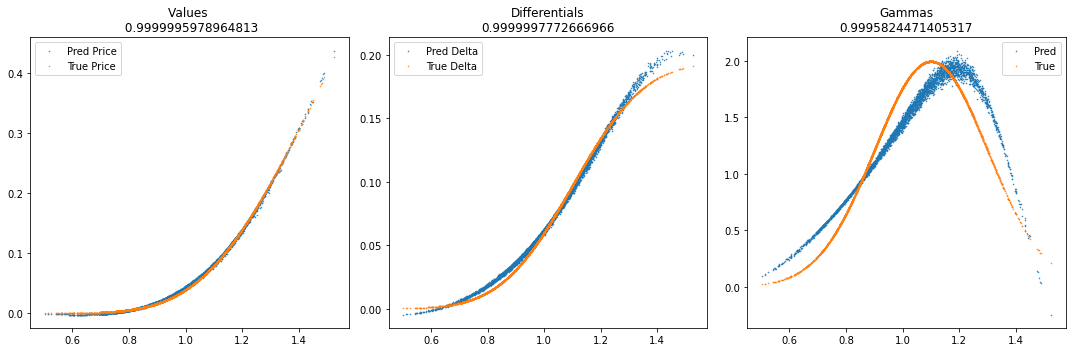

In [170]:
pred = predict(eqx_pruned_model, x_test)
plot_eval(eqx_pruned_model, pred, test_set, "eqx_pruned_model")

# Retrain pruned model

In [222]:
pruned_normalized_model = lambda x, params: y_denormalizer(jax_func(model_params, [x_normalizer(x)])[0].squeeze())

In [223]:
jax.vmap(pruned_normalized_model, (0, None))(x_test, model_params)

Array([0.05999186, 0.23548578, 0.1285118 , ..., 0.23350969, 0.01738596,
       0.02404834], dtype=float64)

In [224]:
class PrunedMLP(eqx.Module):
    
    params: PyTree
    f: Callable
    
    def __init__(self, pruned_model, init_params):
        self.params = init_params
        self.f = pruned_model
        
    def __call__(self, x, key=None):
        return self.f(x, self.params)

In [225]:
pruned_mlp = PrunedMLP(pruned_normalized_model, model_params)

In [226]:
jax.jit(jax.vmap(pruned_mlp))(x_test)

Array([0.05999186, 0.23548578, 0.1285118 , ..., 0.23350969, 0.01738596,
       0.02404834], dtype=float64)

In [227]:
def bachelier_retrain_pruned_ml(key: Array, model):
    key, subkey = jax.random.split(key)
    num_epochs = 100
    optim = optax.adam(learning_rate=0.0001)
    model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)
    return model

In [228]:
generator_train_ds, generator_test_ds, x_test = gen_data_standard_ml()
key = jrandom.PRNGKey(0)
retrained_pruned_model = bachelier_retrain_pruned_ml(key, pruned_mlp)

Finished epoch   0  | Train Loss: 0.00138  | Test Loss: 0.00522
Finished epoch   1  | Train Loss: 0.00160  | Test Loss: 0.00522
Finished epoch   2  | Train Loss: 0.00110  | Test Loss: 0.00522
Finished epoch   3  | Train Loss: 0.00149  | Test Loss: 0.00522
Finished epoch   4  | Train Loss: 0.00145  | Test Loss: 0.00522
Finished epoch   5  | Train Loss: 0.00138  | Test Loss: 0.00522
Finished epoch   6  | Train Loss: 0.00159  | Test Loss: 0.00522
Finished epoch   7  | Train Loss: 0.00160  | Test Loss: 0.00522
Finished epoch   8  | Train Loss: 0.00143  | Test Loss: 0.00522
Finished epoch   9  | Train Loss: 0.00174  | Test Loss: 0.00522
Finished epoch  10  | Train Loss: 0.00122  | Test Loss: 0.00522
Finished epoch  11  | Train Loss: 0.00140  | Test Loss: 0.00522
Finished epoch  12  | Train Loss: 0.00125  | Test Loss: 0.00522
Finished epoch  13  | Train Loss: 0.00151  | Test Loss: 0.00522
Finished epoch  14  | Train Loss: 0.00153  | Test Loss: 0.00522
Finished epoch  15  | Train Loss: 0.0015

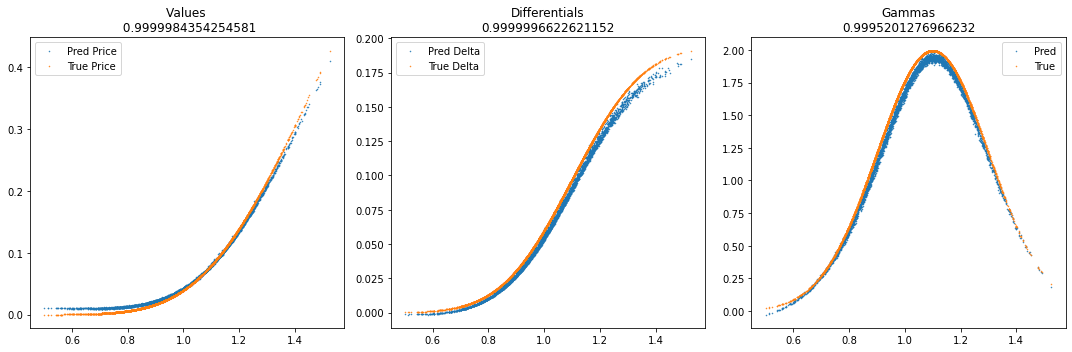

In [229]:
pred = predict(retrained_pruned_model, x_test)
plot_eval(retrained_pruned_model, pred, test_set, "retrained_pruned_ml")

In [236]:
retrained_pruned_model#.params["const_fold_opt__112"]

PrunedMLP(
  params={
    'Const_15:0':
    f64[128,128],
    'Const_27:0':
    f64[128,128],
    'Const_39:0':
    f64[128,128],
    'Const_3:0':
    f64[128,7],
    'Const_51:0':
    f64[128,128],
    'Const_63:0':
    f64[93,128],
    'Const_75:0':
    f64[1,93],
    'const_fold_opt__101':
    f64[128,1],
    'const_fold_opt__104':
    f64[128,1],
    'const_fold_opt__106':
    f64[128,1],
    'const_fold_opt__109':
    f64[93,1],
    'const_fold_opt__111':
    i64[1],
    'const_fold_opt__112':
    f64[128,1],
    'const_fold_opt__115':
    f64[128,1],
    'const_fold_opt__116':
    f64[1,1],
    'jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/BroadcastTo_6:0':
    f64[1,1],
    'new_shape__89':
    i64[2]
  },
  f=<function <lambda>>
)

In [237]:
pruned_mlp.params["const_fold_opt__112"]

PrunedMLP(
  params={
    'new_shape__89':
    i64[2],
    'jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/BroadcastTo_6:0':
    f64[1,1],
    'const_fold_opt__116':
    f64[1,1],
    'const_fold_opt__115':
    f64[128,1],
    'const_fold_opt__112':
    f64[128,1],
    'const_fold_opt__111':
    i64[1],
    'const_fold_opt__109':
    f64[93,1],
    'const_fold_opt__106':
    f64[128,1],
    'const_fold_opt__104':
    f64[128,1],
    'const_fold_opt__101':
    f64[128,1],
    'Const_75:0':
    f64[1,93],
    'Const_63:0':
    f64[93,128],
    'Const_51:0':
    f64[128,128],
    'Const_39:0':
    f64[128,128],
    'Const_3:0':
    f64[128,7],
    'Const_27:0':
    f64[128,128],
    'Const_15:0':
    f64[128,128]
  },
  f=<function <lambda>>
)

In [238]:
for i in pruned_mlp.params:
    print(i)

new_shape__89
jax2tf_unknown_/vmap/eqx.nn.MLP/eqx.nn.Linear/pjit_fn_/BroadcastTo_6:0
const_fold_opt__116
const_fold_opt__115
const_fold_opt__112
const_fold_opt__111
const_fold_opt__109
const_fold_opt__106
const_fold_opt__104
const_fold_opt__101
Const_75:0
Const_63:0
Const_51:0
Const_39:0
Const_3:0
Const_27:0
Const_15:0


In [ ]:
pruned_mlp.params["Const_63:0"]

#### retrained_pruned_model.params["Const_63:0"]